In [4]:
import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import psd_array_welch, psd_array_multitaper
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
import sys
import numpy

sys.path.insert(0, "C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions")
import MEG_pareidolia_utils

import PARAMS
from PARAMS import *
import fooof
from fooof import FOOOF

# import brainpipe
# from brainpipe import feature
import pandas as pd
import scipy.io as sio
from scipy.io import savemat, loadmat
from MEG_pareidolia_utils import *
import PARAMS
from PARAMS import *

RUN_LIST = {"pareidolia": ["1", "2", "3", "4", "5", "6"], "RS": ["1", "2"]}
# RUN_LIST = {"pareidolia": ["7"], "RS": ["1", "2"]}
SUBJ_LIST = ["08", "09", "10", "11"]
SUBJ_LIST = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]
TASK_LIST = ["RS"]

# import pdb; pdb.set_trace
SFREQ = 1200  # Sampling frequency
# FREQ_RESOLUTION = 0.1  # Desired frequency resolution
NPERSEG = int(SFREQ / 4)  # Number of points per segment
NPERSEG_short = int(SFREQ / 4)
NFFT = int(SFREQ // 1)  # Number of points in FFT
BANDWIDTH = 8  # Bandwidth of windows in multitaper analysis


def compute_FOOOF(
    freqs1,
    psd,
    sf,
    precision=0.1,
    max_freq=80,
    min_freq=2,
    noverlap=None,
    nperseg=None,
    nfft=None,
    extended_returns=False,
    graph=False,
):
    if nperseg is None:
        mult = 1 / precision
        nfft = sf * mult
        nperseg = nfft
        noverlap = nperseg // 10
    fm = FOOOF(peak_width_limits=[1, 7], max_n_peaks=8, min_peak_height=0.3)

    freq_range = [min_freq, max_freq]
    fm.fit(freqs1, psd, freq_range)
    if graph is True:
        fm.report(freqs1, psd)

    try:
        offset = fm.get_params("aperiodic_params")[0]
        exp = fm.get_params("aperiodic_params")[1]
        print("OFFSET: ", offset)
        print("EXP: ", exp)
    except:
        offset = "NaN"
        exp = "NaN"
    try:
        cf = [x[0] for x in fm.get_params("peak_params")]
        amp = [x[1] for x in fm.get_params("peak_params")]
        width = [x[2] for x in fm.get_params("peak_params")]
    except IndexError:
        cf = "NaN"
        amp = "NaN"
        width = "NaN"
    corrected_spectrum = fm.power_spectrum - fm._ap_fit
    r2 = fm.r_squared_
    print("R2: ", r2)
    return (
        offset,
        exp,
        cf,
        amp,
        width,
        fm.fooofed_spectrum_,
        fm.freq_range,
        fm.freq_res,
        corrected_spectrum,
        r2,
        fm._ap_fit,
    )


# This function is used to compute power values for each frequency bands on each epochs
def compute_psd(epochs, FREQ_BANDS, function=psd_array_welch, tmin=None, tmax=None, fmin=2, fmax=90, task='pareidolia', run=None, new_meta_epochs=None):
    # epochs are cropped as desire (tmin could be before '0', ex: -1.5, depending on the values used during epoching)
    # epochs = epochs.apply_baseline((-1, -0.5))
    epochs.pick_types(meg=True, ref_meg=False)
    epochs = epochs.crop(tmin, tmax)
    print(epochs.get_data().shape)
    PSDs = []
    # condition 1 is when metadata 'parei' = 0, condition 2 is when metadata 'parei' = 1
    PSDs_cond1 = []
    PSDs_cond2 = []
    idxs_cond1 = []
    idxs_cond2 = []
    for t in range(len(epochs[:].get_data())):
        epochs_data = epochs[t].get_data()
        psds, freqs = function(
            epochs_data,
            sfreq=SFREQ,
            fmin=fmin,
            fmax=fmax,
            n_fft=NFFT,
            n_per_seg=NPERSEG,
            n_jobs=-1,
        )
        print("PSDS LONG SHAPE: ", psds.shape)
        print("FREQS LONG SHAPE: ", freqs.shape)
        # print min and max of freqs
        print("FREQS MIN: ", np.min(freqs))
        print("FREQS MAX: ", np.max(freqs))
        if task == 'pareidolia':
            if epochs.metadata.iloc[t]["parei"] == 0:
                PSDs_cond1.append(psds)
            elif epochs.metadata.iloc[t]["parei"] == 1:
                PSDs_cond2.append(psds)
        if task == 'earlyVSlate':
            if epochs.metadata.iloc[t]["earlyVSlate"] == 1:
                PSDs_cond1.append(psds)
                idxs_cond1.append(t)
            elif epochs.metadata.iloc[t]["earlyVSlate"] == 2:
                PSDs_cond2.append(psds)
                idxs_cond2.append(t)
        elif task == 'RS':
            if run == '1':
                PSDs_cond1.append(psds)
            elif run == '2':
                PSDs_cond2.append(psds)
    print('PSDs_cond1 shape: ', np.array(PSDs_cond1).shape)
    print('PSDs_cond2 shape: ', np.array(PSDs_cond2).shape)
    PSDs_cond1 = np.array(PSDs_cond1)
    PSDs_cond1 = np.average(PSDs_cond1, axis=0)
    print('PSDs_cond1 shape: ', PSDs_cond1.shape)
    PSDs_cond2 = np.array(PSDs_cond2)
    PSDs_cond2 = np.average(PSDs_cond2, axis=0)
    print('PSDs_cond2 shape: ', PSDs_cond2.shape)
    return PSDs_cond1, PSDs_cond2, freqs, idxs_cond1, idxs_cond2




In [137]:
run

'6'

In [7]:

##Compute_PSD
slopes_cond1_subj = []
slopes_cond2_subj = []
offsets_cond1_subj = []
offsets_cond2_subj = []
ap_fit_cond1_subj = []
ap_fit_cond2_subj = []
fooofed_spectrum_cond1_subj = []
fooofed_spectrum_cond2_subj = []
corrected_spectrum_cond1_subj = []
corrected_spectrum_cond2_subj = []
for subj in SUBJ_LIST:
    for task in TASK_LIST:
        psds_cond1_all = []
        psds_cond2_all = []
        for run in RUN_LIST[task]:
            try:
                epochs_name, epochs_path = get_pareidolia_bids(
                    FOLDERPATH, subj, task, run, stage="epo_RS", cond=None
                )
                epochs_short = mne.read_epochs(epochs_path)
                print(task)
                # print len of trials when metadata earlyVSlate is 1
                # print(
                #     "len of trials when metadata earlyVSlate is 1: ",
                #     len(epochs_short[epochs_short.metadata["earlyVSlate"] == 1]),
                #     "len of trials when metadata earlyVSlate is 2: ",
                #     len(epochs_short[epochs_short.metadata["earlyVSlate"] == 2]),
                # )
                # Si vous voulez comparer les epochs entières (8sec), il est mieux de laisser de côté le début et la fin des epochs.
                psds_cond1, psds_cond2, freqs, idxs_cond1, idxs_cond2 = compute_psd(
                    epochs_short,
                    FREQ_BANDS4,
                    psd_array_welch,
                    tmin=0,
                    tmax=3,
                    fmin=3,
                    fmax=90,
                    task='RS',
                    run=run,
                )
                print("FREQS ALL SHAPE: ", freqs.shape)
                print("PSDS ALL SHAPE: ", psds_cond1.shape)

                psds_cond1 = np.average(psds_cond1, axis=0)  # remove empty dimension
                psds_cond2 = np.average(psds_cond2, axis=0)  # remove empty dimension
                psds_cond1_all.append(psds_cond1)
                psds_cond2_all.append(psds_cond2)
            except (FileNotFoundError, numpy.AxisError):
                pass
        psds_cond1_all = np.array(psds_cond1_all)
        psds_cond2_all = np.array(psds_cond2_all)
        psds_cond1_all = np.average(psds_cond1_all, axis=0)
        psds_cond2_all = np.average(psds_cond2_all, axis=0)            
        slopes_cond1 = []
        slopes_cond2 = []
        offsets_cond1 = []
        offsets_cond2 = []
        ap_fit_cond1 = []
        ap_fit_cond2 = []
        fooofed_spectrum_cond1 = []
        fooofed_spectrum_cond2 = []
        corrected_spectrum_cond1 = []
        corrected_spectrum_cond2 = []
        for elec in range(len(psds_cond1_all)):
            print("ELEC: ", elec)
            offset1, exp1, _, _, fooofed1, _, _, _, corrected1, _, slope_cond1 = compute_FOOOF(
                freqs,
                psds_cond1_all[elec],
                1200,
                precision=0.1,
                max_freq=90,
                min_freq=3,
                noverlap=None,
                nperseg=None,
                nfft=None,
                extended_returns=False,
                graph=False,
            )
            print("SLOPE COND1: ", slope_cond1.shape)
            offset2, exp2, _, _, fooofed2, _, _, _, corrected2, _, slope_cond2 = compute_FOOOF(
                freqs,
                psds_cond2_all[elec],
                1200,
                precision=0.1,
                max_freq=90,
                min_freq=3,
                noverlap=None,
                nperseg=None,
                nfft=None,
                extended_returns=False,
                graph=False,
            )
            print("SLOPE COND2: ", slope_cond2.shape)
            # create exp_dist1 which is the diff between the value and 1
            # create exp_dist2 which is the diff between the value and 1
            exp_dist1 = abs(exp1 - 1)
            exp_dist2 = abs(exp2 - 1)
            slopes_cond1.append(exp1)
            slopes_cond2.append(exp2)
            offsets_cond1.append(offset1)
            offsets_cond2.append(offset2)
            ap_fit_cond1.append(slope_cond1)
            ap_fit_cond2.append(slope_cond2)
            fooofed_spectrum_cond1.append(fooofed1)
            fooofed_spectrum_cond2.append(fooofed2)
            corrected_spectrum_cond1.append(corrected1)
            corrected_spectrum_cond2.append(corrected2)
    slopes_cond1_subj.append(slopes_cond1)
    slopes_cond2_subj.append(slopes_cond2)
    offsets_cond1_subj.append(offsets_cond1)
    offsets_cond2_subj.append(offsets_cond2)
    ap_fit_cond1_subj.append(ap_fit_cond1)
    ap_fit_cond2_subj.append(ap_fit_cond2)
    fooofed_spectrum_cond1_subj.append(fooofed_spectrum_cond1)
    fooofed_spectrum_cond2_subj.append(fooofed_spectrum_cond2)
    corrected_spectrum_cond1_subj.append(corrected_spectrum_cond1)
    corrected_spectrum_cond2_subj.append(corrected_spectrum_cond2)


Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-1_epo_RS.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available


C:\Users\Antoine\AppData\Local\Temp\ipykernel_6216\1611374201.py:21: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    2.9s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    3.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.1s finished


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (1, 270, 88)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-2_epo_RS.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()


c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

## RS slopes

In [94]:
# This function is used to compute power values for each frequency bands on each epochs
def compute_psd_RS(epochs, FREQ_BANDS, function=psd_array_welch, tmin=None, tmax=None, fmin=2, fmax=90, run=None):
    # epochs are cropped as desire (tmin could be before '0', ex: -1.5, depending on the values used during epoching)
    # epochs = epochs.apply_baseline((-1, -0.5))
    epochs.pick_types(meg=True, ref_meg=False)
    epochs = epochs.crop(tmin, tmax)
    print(epochs.get_data().shape)
    PSDs = []
    # condition 1 is when metadata 'parei' = 0, condition 2 is when metadata 'parei' = 1
    PSDs_cond1 = []
    PSDs_cond2 = []

    for t in range(len(epochs[:].get_data())):
        epochs_data = epochs[t].get_data()
        psds, freqs = function(
            epochs_data,
            sfreq=SFREQ,
            fmin=fmin,
            fmax=fmax,
            n_fft=NFFT,
            n_per_seg=NPERSEG,
            n_jobs=-1,
        )
        print("PSDS LONG SHAPE: ", psds.shape)
        print("FREQS LONG SHAPE: ", freqs.shape)
        # print min and max of freqs
        print("FREQS MIN: ", np.min(freqs))
        print("FREQS MAX: ", np.max(freqs))
        if run == '1':
            PSDs_cond1.append(psds)
        elif run == '2':
            PSDs_cond2.append(psds)
    print('PSDs_cond1 shape: ', np.array(PSDs_cond1).shape)
    print('PSDs_cond2 shape: ', np.array(PSDs_cond2).shape)
    PSDs_cond1 = np.array(PSDs_cond1)
    PSDs_cond1 = np.average(PSDs_cond1, axis=0)
    print('PSDs_cond1 shape: ', PSDs_cond1.shape)
    PSDs_cond2 = np.array(PSDs_cond2)
    PSDs_cond2 = np.average(PSDs_cond2, axis=0)
    print('PSDs_cond2 shape: ', PSDs_cond2.shape)
    return PSDs_cond1, PSDs_cond2, freqs

##Compute_PSD
slopes_cond1_subj = []
slopes_cond2_subj = []
offsets_tot_subj = []
for subj in SUBJ_LIST:
    for task in TASK_LIST:
        psds_cond1_all = []
        psds_cond2_all = []
        for run in RUN_LIST[task]:
            try:
                epochs_name, epochs_path = get_pareidolia_bids(
                    FOLDERPATH, subj, task, run, stage="epo_RS", cond=None
                )
                epochs_short = mne.read_epochs(epochs_path)
                print(task)
                
                # Si vous voulez comparer les epochs entières (8sec), il est mieux de laisser de côté le début et la fin des epochs.
                psds_cond1, psds_cond2, freqs = compute_psd(
                    epochs_short,
                    FREQ_BANDS4,
                    psd_array_welch,
                    tmin=0,
                    tmax=3,
                    fmin=3,
                    fmax=90,
                    task=task,
                    run=run,
                )
                if run == '1':
                    psds_cond1 = np.average(psds_cond1, axis=0)  # remove empty dimension
                    psds_cond1_all.append(psds_cond1)
                elif run == '2':
                    psds_cond2 = np.average(psds_cond2, axis=0)  # remove empty dimension
                    psds_cond2_all.append(psds_cond2)
                print("FREQS ALL SHAPE: ", freqs.shape)
                print("PSDS ALL SHAPE: ", psds_cond1.shape)

                
            except (FileNotFoundError, numpy.AxisError):
                pass
        psds_cond1_all = np.array(psds_cond1_all)
        psds_cond2_all = np.array(psds_cond2_all)
        print('PSDs_cond1_all shape: ', psds_cond1_all.shape)
        print('PSDs_cond2_all shape: ', psds_cond2_all.shape)
        psds_cond1_all = np.average(psds_cond1_all, axis=0)
        psds_cond2_all = np.average(psds_cond2_all, axis=0)            
        slopes_cond1 = []
        slopes_cond2 = []
        offsets_cond1 = []
        offsets_cond2 = []
        for elec in range(len(psds_cond1_all)):
            print("ELEC: ", elec)
            offset1, exp1, _, _, _, _, _, _, _, _, slope_cond1 = compute_FOOOF(
                freqs,
                psds_cond1_all[elec],
                1200,
                precision=0.1,
                max_freq=90,
                min_freq=3,
                noverlap=None,
                nperseg=None,
                nfft=None,
                extended_returns=False,
                graph=False,
            )
            print("SLOPE COND1: ", slope_cond1.shape)
            offset2, exp2, _, _, _, _, _, _, _, _, slope_cond2 = compute_FOOOF(
                freqs,
                psds_cond2_all[elec],
                1200,
                precision=0.1,
                max_freq=90,
                min_freq=3,
                noverlap=None,
                nperseg=None,
                nfft=None,
                extended_returns=False,
                graph=False,
            )
            print("SLOPE COND2: ", slope_cond2.shape)
            slopes_cond1.append(exp1)
            slopes_cond2.append(exp2)
            offsets_cond1.append(offset1)
            offsets_cond2.append(offset2)
    slopes_cond1_subj.append(slopes_cond1)
    slopes_cond2_subj.append(slopes_cond2)

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-1_epo_RS.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available


C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    2.6s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    2.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-2_epo_RS.fif ...
    Read 5 compensation matrices


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.555916001667367
EXP:  1.1246196050226376
R2:  0.9591798373750597
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the freque

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.87776478738857
EXP:  1.4821715050769753
R2:  0.9907284099955564
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequen

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\l

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(40, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (40, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.36314938028879
EXP:  1.2519609847325088
R2:  0.9850745347148834
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit ma

c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OFFSET:  -25.493989761098792
EXP:  1.6634813175533016
R2:  0.9902476878481253
SLOPE COND2:  (88,)
ELEC:  16

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.100995782069596
EXP:  1.3387210338864544
R2:  0.9836047873996177
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.825307868801676
EXP:  1.4622932548853986
R2:  0.9820193798078527
SLOPE COND2:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-03\ses-recording\meg\sub-03_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-03\ses-recording\meg\sub-03_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\l

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower boun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

OFFSET:  -26.129627943513178
EXP:  1.3985341521074954
R2:  0.9891491673140551
SLOPE COND2:  (88,)
ELEC:  3

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.089447515295866
EXP:  1.3745137606903353
R2:  0.9763679085051027
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.970391983987206
EXP:  1.4409934542489469
R2:  0.9893533447208986
SLOPE COND2: 

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.42966163751026
EXP:  1.2520865972842312
R2:  0.961906710051176
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequen

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

OFFSET:  -26.184012421715593
EXP:  1.3559014521371922
R2:  0.968562655207497
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.651158457819136
EXP:  1.0646160870364654
R2:  0.9913615353080036
SLOPE COND2:  (88,)
ELEC:  3

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.23882602858034
EXP:  1.2915375260298163
R2:  0.985271869144943
SLOPE COND1:  (8

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.72637995839211
EXP:  1.1834731910179817
R2:  0.9753015014112625
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequen

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-2_epo_RS.fif) does not conform to MNE naming conventions. All epochs f

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.210367235339483
EXP:  1.3450770513382775
R2:  0.9694675151846

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

OFFSET:  -26.09384132651287
EXP:  1.3701829049091725
R2:  0.9669500281985197
SLOPE COND2:  (88,)
ELEC:  2

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.06336785852108
EXP:  1.3892664246870208
R2:  0.9704533902610073
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.075255481629366
EXP:  1.3884608001373864
R2:  0.9813128924222159
SLOPE COND2:  (

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.82064728275506
EXP:  1.0267623765585552
R2:  0.9720086988877784
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

OFFSET:  -26.230456147021588
EXP:  1.1412893237284096
R2:  0.9368391474114349
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.89749901460005
EXP:  1.4953653976544505
R2:  0.9807567318072535
SLOPE COND2:  (88,)
ELEC:  7

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.30777017503186
EXP:  1.2621375826224082
R2:  0.9684767286753814
SLOPE COND1:  (

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-2_epo_RS.fif ...


c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-2_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.024413178011628
EXP:  1.4348912666124745
R2:  0.9694488230486149
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequen

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OFFSET:  -25.67318001832502
EXP:  1.607101310763862
R2:  0.9838351670605623
SLOPE COND2:  (88,)
ELEC:  5

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.52843788598098
EXP:  1.60112223300821
R2:  0.987415999172083
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.44208605861281
EXP:  1.7505750592955676
R2:  0.9855316395334989
SLOPE COND2:  (88,)


C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-09\ses-recording\meg\sub-09_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-09\ses-recording\meg\sub-09_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

(1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.796020039935325
EXP:  1.0862845699824608
R2:  0.9908400761112456
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the freque

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-2_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.387796094279558
EXP:  1.2578164110916703
R2:  0.9739357800930564
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit m

C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-1_epo_RS.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurren

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remainin

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (59, 1, 270, 88)
PSDs_cond2 shape:  (0,)
PSDs_cond1 shape:  (1, 270, 88)
PSDs_cond2 shape:  ()
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  (270, 88)
Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-2_epo_RS.fif ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\542651096.py:56: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-2_epo_RS.fif) does not conform to MNE naming conventions. All epochs f

    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        5 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
RS
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(59, 270, 3601)
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

 (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s


PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   

PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
Effective window size : 1.000 (s)
PSDS LONG SHAPE:  (1, 270, 88)
FREQS LONG SHAPE:  (88,)
FREQS MIN:  3.0
FREQS MAX:  90.0
PSDs_cond1 shape:  (0,)
PSDs_cond2 shape:  (59, 1, 270, 88)
PSDs_cond1 shape:  ()
PSDs_cond2 shape:  (1, 270, 88)
FREQS ALL SHAPE:  (88,)
PSDS ALL SHAPE:  ()
PSDs_cond1_all shape:  (1, 270, 88)
PSDs_cond2_all shape:  (1, 270, 88)
ELEC:  0

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.35914326647422
EXP:  1.2854408565715163
R2:  0.97237818074325

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-pack

OFFSET:  -25.978923611291467
EXP:  1.4323896416464723
R2:  0.9877632243000375
SLOPE COND1:  (88,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -26.16642049099811
EXP:  1.3705027147969038
R2:  0.9898548430796641
SLOPE COND2:  (88,)
ELEC:  5

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

OFFSET:  -25.88616711327585
EXP:  1.5226740082191026
R2:  0.9889418090157062
SLOPE COND1:  (

TTEST SLOPE:  TtestResult(statistic=2.8607088182149996, pvalue=0.004558645065417972, df=269)


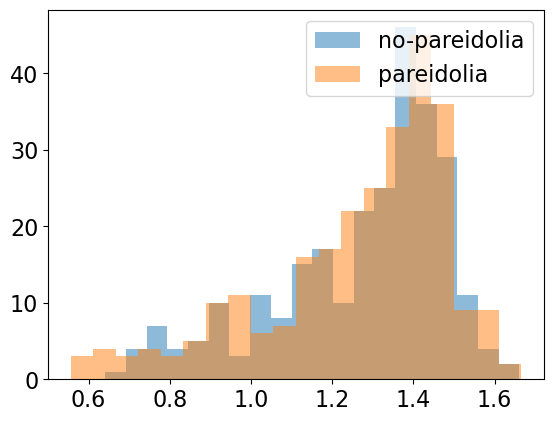

In [456]:
# make t-test to compare slopes between conditions

slopes_cond1 = np.array(slopes_cond1)
slopes_cond2 = np.array(slopes_cond2)
offsets_cond1 = np.array(offsets_cond1)
offsets_cond2 = np.array(offsets_cond2)

ttest_slope = stats.ttest_rel(slopes_cond1, slopes_cond2)
#ttest_offset = stats.ttest_rel(offsets_cond1, offsets_cond2)
print("TTEST SLOPE: ", ttest_slope)
#print("TTEST OFFSET: ", ttest_offset)

# plot distribution of slopes
plt.figure()
plt.hist(slopes_cond1, bins=20, alpha=0.5, label="no-pareidolia")
plt.hist(slopes_cond2, bins=20, alpha=0.5, label="pareidolia")
plt.legend(loc="upper right")



C:\Users\Antoine\AppData\Local\Temp\ipykernel_16708\49957511.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_ttests, bins=20, kde=True, rug=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF SLOPES COND1 SUBJ:  12
LENGTH OF 

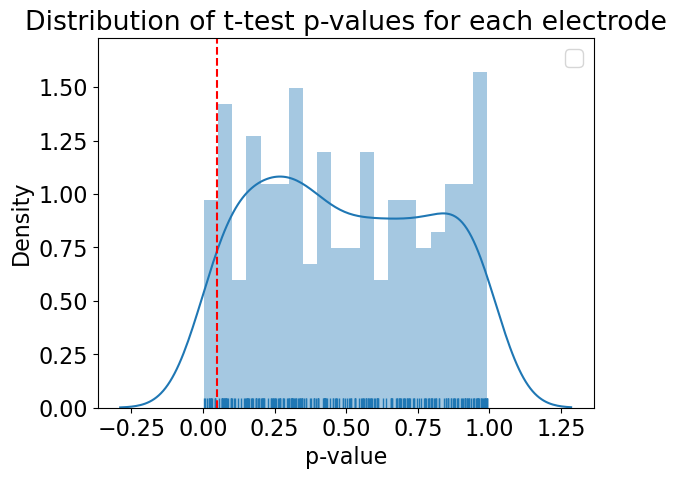

In [32]:
import seaborn as sns
slopes_cond1_subj = np.array(slopes_cond1_subj)
slopes_cond2_subj = np.array(slopes_cond2_subj)

slopes_cond1_subjavg = np.average(slopes_cond1_subj, axis=1)
slopes_cond2_subjavg = np.average(slopes_cond2_subj, axis=1)

all_ttests = []
all_tvals = []
for elec in range(len(slopes_cond1_subj[0])):
    print('LENGTH OF SLOPES COND1 SUBJ: ', len(slopes_cond1_subj[:, elec]))
    ttest_slope = stats.ttest_rel(
        slopes_cond1_subj[:, elec], slopes_cond2_subj[:, elec]
    )

    all_ttests.append(ttest_slope[1])
    all_tvals.append(ttest_slope[0])

# plot distribution of t-test p-values
plt.figure()
sns.distplot(all_ttests, bins=20, kde=True, rug=True)
# add a vertical line at p = 0.05
plt.axvline(x=0.05, color="r", linestyle="--")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.title("Distribution of t-test p-values for each electrode")
plt.legend(loc="upper right")

# calculate the number of electrodes with p-value < 0.05
pval05 = []
pval05_idx = []
for p in all_ttests:
    if p < 0.05:
        pval05.append(p)
        pval05_idx.append(all_ttests.index(p))

print("NUMBER OF ELECS WITH P-VALUE < 0.05: ", len(pval05))
print("ELECS WITH P-VALUE < 0.05: ", pval05_idx)

In [440]:
from mne.io import read_raw_fif
preproc_name, preproc_path = get_pareidolia_bids(
        FOLDERPATH, subj, task, run, stage="preproc"
    )
preproc = read_raw_fif(preproc_path, preload=True)
events = mne.find_events(preproc, shortest_event=1)

Opening raw data file D:\Science\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-pareidolia_run-6_preproc_raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 732868 =      0.000 ...   610.723 secs
Ready.
Current compensation grade : 3
Reading 0 ... 732868  =      0.000 ...   610.723 secs...
Trigger channel has a non-zero initial value of 11 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
184 events found
Event IDs: [3 4 5 6]


In [444]:


behav_name, behav_path = get_pareidolia_bids(
            FOLDERPATH, subj, task, "1", stage="behav"
        )
behav = pd.read_csv(behav_path)
behav = arrange_dataframe(behav)

behav = behav.loc[behav["bloc"] == int(run)]
# print(behav)
FDlist = list(np.array(behav["FD"]))
Contrast = list(np.array(behav["Contrast"]))
n_objects_list = list(np.array(behav["positive_n_objets"]))
n_objects_list = np.nan_to_num(n_objects_list)
n_obj_class = n_obj2class(n_objects_list)
parei = [1 if x == 2 else x for x in n_obj_class]
events, medianRT, RT = reformat_events_meta(
    events,
    FDlist=FDlist,
    RT_thresh=RT_thresh,
    task=task,
    run=run,
    n_objects_list=n_objects_list,
)

events2, medianRT, RT = reformat_events_meta(
            events,
            FDlist=FDlist,
            RT_thresh=RT_thresh,
            task=task,
            run=run,
            n_objects_list=n_objects_list,
        )

medianRT 5500
medianRT 5000


c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [447]:
e = 5
events[e][0] - events[e - 1][0]

7829

In [445]:
events2

array([[  1151,      0,      3],
       [  2984,      0,      4],
       [ 12542,      0,      5],
       [ 14771,      0,      3],
       [ 16594,      0,     44],
       [ 24423,      0,      6],
       [ 26171,      0,      5],
       [ 28223,      0,      3],
       [ 30045,      0,     44],
       [ 37023,      0,      6],
       [ 39631,      0,      5],
       [ 41903,      0,      3],
       [ 43733,      0,     44],
       [ 43833,      0,    666],
       [ 53303,      0,      5],
       [ 55771,      0,      3],
       [ 57610,      0,     44],
       [ 57710,      0,    666],
       [ 67171,      0,      5],
       [ 69211,      0,      3],
       [ 71044,      0,     44],
       [ 77054,      0,      6],
       [ 80612,      0,      5],
       [ 83023,      0,      3],
       [ 84851,      0,     44],
       [ 88553,      0,      6],
       [ 94432,      0,      5],
       [ 97332,      0,      3],
       [ 99163,      0,     44],
       [104623,      0,      6],
       [10

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...


C:\Users\Antoine\AppData\Local\Temp\ipykernel_16708\2981138256.py:6: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 259, 260, 261, 262]


(<Figure size 1000x500 with 2 Axes>, <AxesSubplot:>)

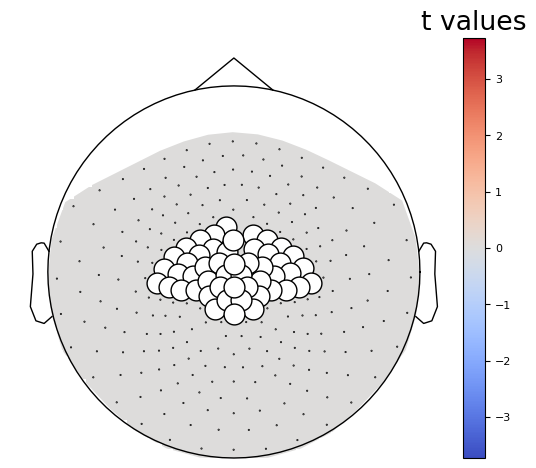

In [34]:
from MEG_pareidolia_utils import topoplot
from PARAMS import *
epochs_name, epochs_path = get_pareidolia_bids(
    FOLDERPATH, "00", "pareidolia", "1", stage="epo_long", cond=None
)
epochs = mne.read_epochs(epochs_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info
# run FDR correction
from statsmodels.stats.multitest import fdrcorrection
mask_idx = MEG_atlas['CL'] + MEG_atlas['CR'] + MEG_atlas['CZ']
print(mask_idx)
# create boolean mask for mask_idx
mask = np.zeros(len(ch_xy['ch_names']), dtype=bool)
mask[mask_idx] = True
# create vector of 270 1s
pvals_bool = np.zeros(len(ch_xy['ch_names']))
topoplot(
    pvals_bool,
    ch_xy,
    showtitle=False,
    titles='Slopes_t-test.png',
    savefig=True,
    figpath=".",
    vmin=-np.max(all_tvals),
    vmax=np.max(all_tvals),
    ax_title="t values",
    mask=mask,
    cmap="coolwarm",
    mask_marker_size=15,
)

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...
    Found the data of interest:


C:\Users\Antoine\AppData\Local\Temp\ipykernel_16708\1973928305.py:5: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NUMBER OF ELECS WITH P-VALUE < 0.05 AFTER FDR CORRECTION:  270


(<Figure size 1000x500 with 2 Axes>, <AxesSubplot:>)

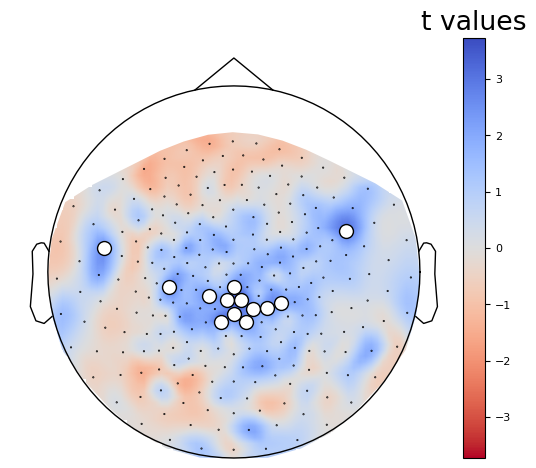

In [25]:
from MEG_pareidolia_utils import topoplot
epochs_name, epochs_path = get_pareidolia_bids(
    FOLDERPATH, "00", "pareidolia", "1", stage="epo_long", cond=None
)
epochs = mne.read_epochs(epochs_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info
# run FDR correction
from statsmodels.stats.multitest import fdrcorrection


mask = fdrcorrection(all_ttests, alpha=0.05, method='indep')

pvals_bool = []
for p in all_ttests:
    if p < 0.05:
        pvals_bool.append(True)
    else:
        pvals_bool.append(False)
print("NUMBER OF ELECS WITH P-VALUE < 0.05 AFTER FDR CORRECTION: ", len(all_ttests))
topoplot(
    all_tvals,
    ch_xy,
    showtitle=False,
    titles='Slopes_t-test.png',
    savefig=True,
    figpath=".",
    vmin=-np.max(all_tvals),
    vmax=np.max(all_tvals),
    ax_title="t values",
    mask=np.array(pvals_bool),
    cmap="coolwarm_r",
    mask_marker_size=10,
)

In [431]:
epochs_short.metadata

FD  FD_class  n_obj  n_obj_class  parei  contrast  earlyVSlate
1    1.725         2    0.0            0      0       0.0            0
4    1.875         2    0.0            0      0       0.0            0
7    1.950         2    0.0            0      0       0.0            0
10   1.425         1    1.0            1      1       1.0          100
14   1.425         1    1.0            1      1       0.0            2
18   1.350         1    1.0            1      1       0.0            2
22   1.050         0    2.0            2      1       1.0            2
26   1.650         1    3.0            2      1       0.0            1
30   1.875         2    1.0            1      1       1.0            2
34   1.800         2    2.0            2      1       0.0            1
38   1.275         0    1.0            1      1       1.0          100
42   1.500         1    1.0            1      1       1.0            2
46   1.950         2    0.0            0      0       1.0            0
49   1.500         1    3.0            2      1       0.0            1
53   1.050         0    1.0            1      1       0.0            2
57   1.275         0    0.0            0      0       0.0            0
60   1.725         2    2.0            2      1       1.0            1
64   1.125         0    0.0            0      0       1.0            0
67   1.800         2    2.0            2      1       1.0            2
71   1.650         1    1.0            1      1       1.0            2
75   1.575         1    1.0            1      1       1.0            2
79   1.200         0    1.0            1      1       1.0          100
83   1.350         1    1.0            1      1       1.0            2
87   1.125         0    0.0            0      0       0.0            0
90   1.200         0    1.0            1      1       0.0            2
94   1.575         1    2.0            2      1       0.0            1
98   1.575         1    4.0            2      1       0.0            1
102  1.800         2    0.0            0      0       0.0            0
105  1.275         0    2.0            2      1       0.0            1
109  1.425         1    1.0            1      1       1.0            2
113  1.425         1    0.0            0      0       0.0            0
116  1.275         0    2.0            2      1       1.0            2
120  1.650         1    1.0            1      1       1.0            1
124  1.200         0    0.0            0      0       0.0            0
127  1.350         1    3.0            2      1       0.0            1
131  1.500         1    2.0            2      1       0.0            2
135  1.050         0    1.0            1      1       1.0            2
139  1.125         0    2.0            2      1       0.0            2
143  1.725         2    2.0            2      1       0.0            2
147  1.050         0    1.0            1      1       0.0            2
151  1.650         1    1.0            1      1       0.0            2
155  1.350         1    0.0            0      0       1.0            0
158  1.575         1    2.0            2      1       1.0            1
162  1.200         0    0.0            0      0       1.0            0
165  1.875         2    2.0            2      1       0.0            2
169  1.950         2    2.0            2      1       1.0            2
173  1.725         2    3.0            2      1       1.0            2
177  1.125         0    1.0            1      1       1.0            1
181  1.875         2    1.0            1      1       1.0            2
185  1.800         2    2.0            2      1       1.0            1
189  1.500         1    5.0            2      1       1.0            1
193  1.950         2    2.0            2      1       0.0            2

In [142]:
ap_fit_cond1_subj = np.array(ap_fit_cond1_subj)
ap_fit_cond2_subj = np.array(ap_fit_cond2_subj)

ap_fit_cond1_subj.shape

(12, 270, 88)

Text(0.5, 1.0, 'Average aperiodic fit for each condition')

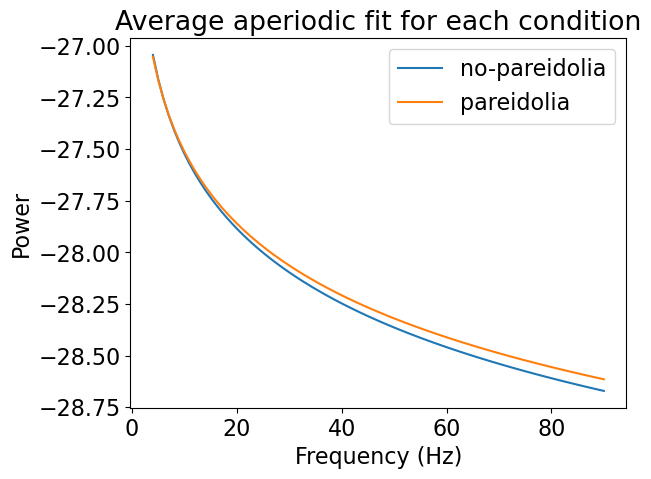

In [430]:
# plot the curve of the average aperiodic fit for each condition
plt.figure()
ap_cond1_subjavg = np.average(ap_fit_cond1_subj, axis=0)
ap_cond2_subjavg = np.average(ap_fit_cond2_subj, axis=0)
plt.plot(freqs, np.average(ap_cond1_subjavg, axis=0), label="no-pareidolia")
plt.plot(freqs, np.average(ap_cond2_subjavg, axis=0), label="pareidolia")
plt.legend(loc="upper right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Average aperiodic fit for each condition")



In [175]:
len(corrected_spectrum_cond1_subj[0][240])

88

Text(0.5, 1.0, 'Average aperiodic fit for each condition')

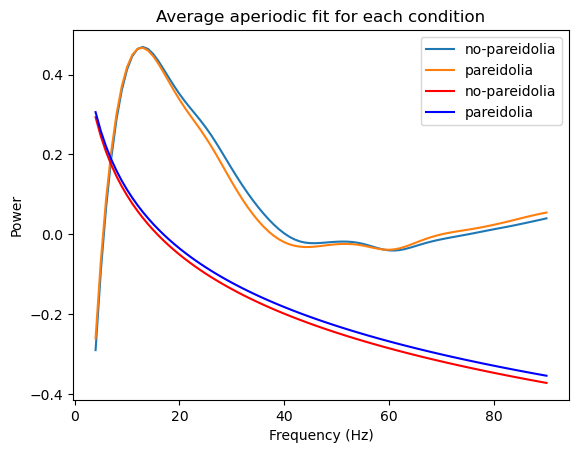

In [362]:
# plot the curve of the average aperiodic fit for each condition
# rescale ap_cond1_subjavg and ap_cond2_subjavg between -0.5 and 0.5

plt.figure()
cond1_subjavg = np.average(np.array(corrected_spectrum_cond1_subj), axis=0)
cond2_subjavg = np.average(np.array(corrected_spectrum_cond2_subj), axis=0)

# normalize ap_cond1_subjavg between -0.5 and 0.5
ap_cond1_subjavg = ap_cond1_subjavg - np.min(ap_cond1_subjavg)
ap_cond1_subjavg = ap_cond1_subjavg / np.max(ap_cond1_subjavg)
ap_cond1_subjavg = ap_cond1_subjavg - 0.5

# normalize ap_cond2_subjavg between -0.5 and 0.5
ap_cond2_subjavg = ap_cond2_subjavg - np.min(ap_cond2_subjavg)
ap_cond2_subjavg = ap_cond2_subjavg / np.max(ap_cond2_subjavg)
ap_cond2_subjavg = ap_cond2_subjavg - 0.5
plt.plot(freqs, np.average(cond1_subjavg, axis=0), label="no-pareidolia")
plt.plot(freqs, np.average(cond2_subjavg, axis=0), label="pareidolia")
plt.plot(freqs, np.average(ap_cond1_subjavg, axis=0), label="no-pareidolia", color='red')
plt.plot(freqs, np.average(ap_cond2_subjavg, axis=0), label="pareidolia", color='blue')
plt.legend(loc="upper right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Average aperiodic fit for each condition")



C:\Users\Antoine\AppData\Local\Temp\ipykernel_16708\412982094.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(slopes_cond1_elecavg, bins=20, kde=True, rug=True, label="early", color='blue', hist_kws={"alpha": 0.2})
C:\Users\Antoine\AppData\Local\Temp\ipykernel_16708\412982094.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

TTEST SLOPE:  TtestResult(statistic=7.430105004515494, pvalue=1.444628308698106e-12, df=269)
DEGREE OF FREEDOM:  269


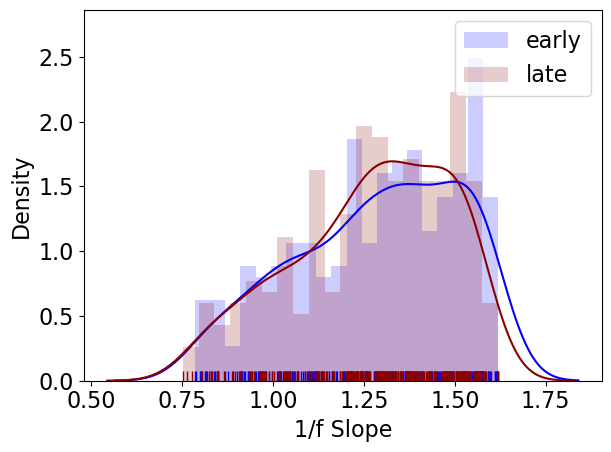

In [33]:
import matplotlib
slopes_cond1_elecavg = np.average(slopes_cond1_subj, axis=0)
slopes_cond2_elecavg = np.average(slopes_cond2_subj, axis=0)

# plot distribution of slopes
plt.figure()
sns.distplot(slopes_cond1_elecavg, bins=20, kde=True, rug=True, label="early", color='blue', hist_kws={"alpha": 0.2})
sns.distplot(slopes_cond2_elecavg, bins=20, kde=True, rug=True, label="late", color='darkred', hist_kws={"alpha": 0.2})
plt.legend(loc="upper right")
plt.xlabel("1/f Slope")
# add a line at the average slope for each condition
#plt.axvline(x=np.average(slopes_cond1_elecavg), color="blue", linestyle="--")
#plt.axvline(x=np.average(slopes_cond2_elecavg), color="darkred", linestyle="--")
# add violin plot

# compute t-test between conditions
ttest_slope = stats.ttest_rel(slopes_cond1_elecavg, slopes_cond2_elecavg)
# increase all font sizes

font = {"size": 16}
matplotlib.rc("font", **font)
print("TTEST SLOPE: ", ttest_slope)
# print degree of freedom
print("DEGREE OF FREEDOM: ", len(slopes_cond1_elecavg) - 1)
plt.tight_layout()
#plt.savefig("Slopes_distribution_earlyVSlate_3sec_real_nperseg300.png")

In [389]:
epochs.metadata

FD  FD_class  n_obj  n_obj_class  parei  contrast  earlyVSlate
1    1.725         2    0.0            0      0       0.0            0
4    1.875         2    0.0            0      0       0.0            0
7    1.950         2    0.0            0      0       0.0            0
10   1.425         1    1.0            1      1       1.0          100
14   1.425         1    1.0            1      1       0.0            2
18   1.350         1    1.0            1      1       0.0            2
22   1.050         0    2.0            2      1       1.0            2
26   1.650         1    3.0            2      1       0.0            1
30   1.875         2    1.0            1      1       1.0            2
34   1.800         2    2.0            2      1       0.0            1
38   1.275         0    1.0            1      1       1.0          100
42   1.500         1    1.0            1      1       1.0            2
46   1.950         2    0.0            0      0       1.0            0
49   1.500         1    3.0            2      1       0.0            1
53   1.050         0    1.0            1      1       0.0            2
57   1.275         0    0.0            0      0       0.0            0
60   1.725         2    2.0            2      1       1.0            1
64   1.125         0    0.0            0      0       1.0            0
67   1.800         2    2.0            2      1       1.0            2
71   1.650         1    1.0            1      1       1.0            2
75   1.575         1    1.0            1      1       1.0            2
79   1.200         0    1.0            1      1       1.0          100
83   1.350         1    1.0            1      1       1.0            2
87   1.125         0    0.0            0      0       0.0            0
90   1.200         0    1.0            1      1       0.0            2
94   1.575         1    2.0            2      1       0.0            1
98   1.575         1    4.0            2      1       0.0            1
102  1.800         2    0.0            0      0       0.0            0
105  1.275         0    2.0            2      1       0.0            1
109  1.425         1    1.0            1      1       1.0            2
113  1.425         1    0.0            0      0       0.0            0
116  1.275         0    2.0            2      1       1.0            2
120  1.650         1    1.0            1      1       1.0            1
124  1.200         0    0.0            0      0       0.0            0
127  1.350         1    3.0            2      1       0.0            1
131  1.500         1    2.0            2      1       0.0            2
135  1.050         0    1.0            1      1       1.0            2
139  1.125         0    2.0            2      1       0.0            2
143  1.725         2    2.0            2      1       0.0            2
147  1.050         0    1.0            1      1       0.0            2
151  1.650         1    1.0            1      1       0.0            2
155  1.350         1    0.0            0      0       1.0            0
158  1.575         1    2.0            2      1       1.0            1
162  1.200         0    0.0            0      0       1.0            0
165  1.875         2    2.0            2      1       0.0            2
169  1.950         2    2.0            2      1       1.0            2
173  1.725         2    3.0            2      1       1.0            2
177  1.125         0    1.0            1      1       1.0            1
181  1.875         2    1.0            1      1       1.0            2
185  1.800         2    2.0            2      1       1.0            1
189  1.500         1    5.0            2      1       1.0            1
193  1.950         2    2.0            2      1       0.0            2

TTEST SLOPE:  TtestResult(statistic=2.352124884057289, pvalue=0.03834322994838288, df=11)


C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\2177098106.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(slopes_cond1_subjavg, hist=False, rug=True, label="pre")
C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\2177098106.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

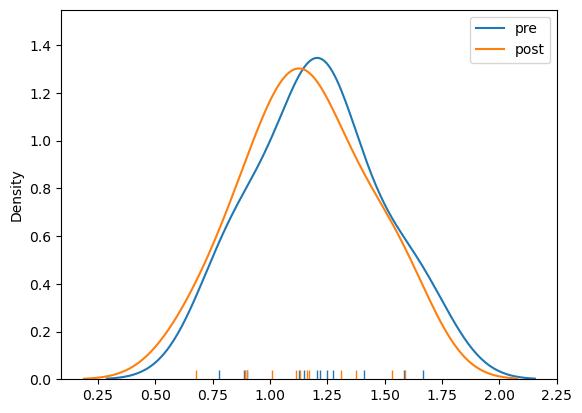

In [191]:
# perform t-test on slopes between conditions
ttest_slope = stats.ttest_rel(slopes_cond1_subjavg, slopes_cond2_subjavg)
print("TTEST SLOPE: ", ttest_slope)

# plot density of slopes using seaborn
import seaborn as sns

sns.distplot(slopes_cond1_subjavg, hist=False, rug=True, label="pre")
sns.distplot(slopes_cond2_subjavg, hist=False, rug=True, label="post")
plt.legend(loc="upper right")


In [27]:
subj = "01"
task = "pareidolia"
run = "1"
epochs_name, epochs_path = get_pareidolia_bids(
                    FOLDERPATH, subj, task, run, stage="epo_RT_allchs", cond=None
                )
epochs_short = mne.read_epochs(epochs_path)

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-pareidolia_run-1_epo_RT_allchs.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =   -2500.00 ...    -500.00 ms
        5 CTF compensation matrices available


C:\Users\Antoine\AppData\Local\Temp\ipykernel_24352\1847930667.py:7: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-pareidolia_run-1_epo_RT_allchs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated


In [45]:

import antropy as ant
import sys
sys.path.insert(0, "C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions")
import MEG_pareidolia_utils
from MEG_pareidolia_utils import *
import PARAMS
from PARAMS import *

RUN_LIST = {"pareidolia": ["1", "2", "3", "4", "5", "6"], "RS": ["1", "2"]}
# RUN_LIST = {"pareidolia": ["7"], "RS": ["1", "2"]}
SUBJ_LIST = ["08", "09", "10", "11"]
SUBJ_LIST = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]
TASK_LIST = ["pareidolia"]
# create empty df with columns ['participant', 'run', 'trial', 'LZ']
all_dfs = []
for subj in SUBJ_LIST:
    for task in TASK_LIST:
        for run in RUN_LIST[task]:
            try:
                epochs_name, epochs_path = get_pareidolia_bids(
                        FOLDERPATH, subj, task, run, stage="epo_RT_allchs", cond=None
                    )
                epochs_short = mne.read_epochs(epochs_path)

                df_final = epochs_short.metadata.reset_index(drop=True)
                # add column 'LZ', 'participant', 'run', 'trial'
                df_final["participant"] = subj
                df_final["run"] = run
                df_final["trial"] = np.nan
                df_final["LZ"] = np.nan
                EOG_chs = []
                for ch in epochs_short.info["ch_names"]:
                    if "EEG" in ch:
                        EOG_chs.append(ch)
                print("EOG CHS: ", EOG_chs)
                # get data from EEG057
                data = epochs_short.get_data()
                # get index of EEG057
                idx = epochs_short.info["ch_names"].index("EEG057")
                # get data from EEG057
                data = data[:, idx, :]
                for trial in range(len(data)):
                    binarized = data[trial] > np.mean(data[trial])
                    results = ant.lziv_complexity(binarized, normalize=True)
                    df_final["LZ"][trial] = results
                    df_final["trial"][trial] = trial
                    print("TRIAL: ", trial)
                    print("LZ: ", results)
                all_dfs.append(df_final)
            except (FileNotFoundError):
                pass

all_dfs = pd.concat(all_dfs)



Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_RT_allchs.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =   -2500.00 ...    -500.00 ms
        5 CTF compensation matrices available


C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:23: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_RT_allchs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_short = mne.read_epochs(epochs_path)


Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5892989923852697
TRIAL:  1
LZ:  0.5612371356050188
TRIAL:  2
LZ:  0.43963575622393136
TRIAL:  3
LZ:  0.4536666846140568
TRIAL:  4
LZ:  0.4256048278338059
TRIAL:  5
LZ:  0.4536666846140568
TRIAL:  6
LZ:  0.5051134220445169
TRIAL:  7
LZ:  0.41625087557372226
TRIAL:  8
LZ:  0.4302818039638477
TRIAL:  9
LZ:  0.45834366074409866
TRIAL:  10
LZ:  0.4536666846140568
TRIAL:  11
LZ:  0.36012716201322037
TRIAL:  12
LZ:  0.44431273235397317
TRIAL:  13
LZ:  0.44431273235397317
TRIAL:  14
LZ:  0.3928659949235131
TRIAL:  15
LZ:  0.46302063687414047
TRIAL:  16
LZ:  0.4676976130041823
TRIAL:  17
LZ:  0.49575946978443325
TRIAL:  18
LZ:  0.43963575622393136
TRIAL:  19
LZ:  0.33674228136301126
TRIAL:  20
LZ:  0.6360687536856879
TRIAL:  21
LZ:  0.5846220162552278
TRIAL:  22
LZ:  0.5191443504346424
TRIAL:  23
LZ:  0.5425292310848514
TRI

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3320653052329694
TRIAL:  1
LZ:  0.3460962336230949
TRIAL:  2
LZ:  0.41625087557372226
TRIAL:  3
LZ:  0.47705156526426595
TRIAL:  4
LZ:  0.2852955439325512
TRIAL:  5
LZ:  0.4115738994436804
TRIAL:  6
LZ:  0.3881890187934713
TRIAL:  7
LZ:  0.4676976130041823
TRIAL:  8
LZ:  0.3928659949235131
TRIAL:  9
LZ:  0.31803437684284397
TRIAL:  10
LZ:  0.3835120426634295
TRIAL:  11
LZ:  0.4115738994436804
TRIAL:  12
LZ:  0.3460962336230949
TRIAL:  13
LZ:  0.42092785170376407
TRIAL:  14
LZ:  0.5051134220445169
TRIAL:  15
LZ:  0.3507732097531367
TRIAL:  16
LZ:  0.5097903981745587
TRIAL:  17
LZ:  0.45834366074409866
TRIAL:  18
LZ:  0.3227113529728858
TRIAL:  19
LZ:  0.4256048278338059
TRIAL:  20
LZ:  0.31803437684284397
TRIAL:  21
LZ:  0.4302818039638477
TRIAL:  22
LZ:  0.49575946978443325
TRIAL:  23
LZ:  0.5051134220445169
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4910824936543914
TRIAL:  1
LZ:  0.47705156526426595
TRIAL:  2
LZ:  0.47705156526426595
TRIAL:  3
LZ:  0.4723745891342241
TRIAL:  4
LZ:  0.3928659949235131
TRIAL:  5
LZ:  0.49575946978443325
TRIAL:  6
LZ:  0.369481114273304
TRIAL:  7
LZ:  0.4910824936543914
TRIAL:  8
LZ:  0.44431273235397317
TRIAL:  9
LZ:  0.43495878009388955
TRIAL:  10
LZ:  0.4536666846140568
TRIAL:  11
LZ:  0.4536666846140568
TRIAL:  12
LZ:  0.4068969233136386
TRIAL:  13
LZ:  0.500436445914475
TRIAL:  14
LZ:  0.37415809040334586
TRIAL:  15
LZ:  0.4068969233136386
TRIAL:  16
LZ:  0.500436445914475
TRIAL:  17
LZ:  0.4723745891342241
TRIAL:  18
LZ:  0.43963575622393136
TRIAL:  19
LZ:  0.4723745891342241
TRIAL:  20
LZ:  0.3086804245827603
TRIAL:  21
LZ:  0.45834366074409866
TRIAL:  22
LZ:  0.46302063687414047
TRIAL:  23
LZ:  0.42092785170376407
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5472062072148933
TRIAL:  1
LZ:  0.6126838730354788
TRIAL:  2
LZ:  0.6688075865959807
TRIAL:  3
LZ:  0.5051134220445169
TRIAL:  4
LZ:  0.6267148014256043
TRIAL:  5
LZ:  0.6781615388560643
TRIAL:  6
LZ:  0.6173608491655206
TRIAL:  7
LZ:  0.6781615388560643
TRIAL:  8
LZ:  0.6454227059457716
TRIAL:  9
LZ:  0.6173608491655206
TRIAL:  10
LZ:  0.6921924672461898
TRIAL:  11
LZ:  0.6126838730354788
TRIAL:  12
LZ:  0.6313917775556461
TRIAL:  13
LZ:  0.5986529446453533
TRIAL:  14
LZ:  0.6220378252955624
TRIAL:  15
LZ:  0.5752680639951442
TRIAL:  16
LZ:  0.579945040125186
TRIAL:  17
LZ:  0.5425292310848514
TRIAL:  18
LZ:  0.5705910878651024
TRIAL:  19
LZ:  0.5612371356050188
TRIAL:  20
LZ:  0.6220378252955624
TRIAL:  21
LZ:  0.5425292310848514
TRIAL:  22
LZ:  0.5892989923852697
TRIAL:  23
LZ:  0.6173608491655206
TRIAL:  24
LZ:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.6828385149861061
TRIAL:  1
LZ:  0.45834366074409866
TRIAL:  2
LZ:  0.4910824936543914
TRIAL:  3
LZ:  0.659453634335897
TRIAL:  4
LZ:  0.6828385149861061
TRIAL:  5
LZ:  0.4864055175243496
TRIAL:  6
LZ:  0.5238213265646842
TRIAL:  7
LZ:  0.5191443504346424
TRIAL:  8
LZ:  0.43963575622393136
TRIAL:  9
LZ:  0.17772509294158928
TRIAL:  10
LZ:  0.3881890187934713
TRIAL:  11
LZ:  0.4115738994436804
TRIAL:  12
LZ:  0.45834366074409866
TRIAL:  13
LZ:  0.4115738994436804
TRIAL:  14
LZ:  0.39754297105355496
TRIAL:  15
LZ:  0.31335740071280216
TRIAL:  16
LZ:  0.35545018588317856
TRIAL:  17
LZ:  0.42092785170376407
TRIAL:  18
LZ:  0.3835120426634295
TRIAL:  19
LZ:  0.4536666846140568
TRIAL:  20
LZ:  0.48172854139430776
TRIAL:  21
LZ:  0.43495878009388955
TRIAL:  22
LZ:  0.4068969233136386
TRIAL:  23
LZ:  0.556560159474977
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.2806185678025094
TRIAL:  1
LZ:  0.3835120426634295
TRIAL:  2
LZ:  0.2806185678025094
TRIAL:  3
LZ:  0.2712646155424257
TRIAL:  4
LZ:  0.289972520062593
TRIAL:  5
LZ:  0.3227113529728858
TRIAL:  6
LZ:  0.369481114273304
TRIAL:  7
LZ:  0.33674228136301126
TRIAL:  8
LZ:  0.3227113529728858
TRIAL:  9
LZ:  0.2619106632823421
TRIAL:  10
LZ:  0.4115738994436804
TRIAL:  11
LZ:  0.3460962336230949
TRIAL:  12
LZ:  0.29464949619263486
TRIAL:  13
LZ:  0.37415809040334586
TRIAL:  14
LZ:  0.3648041381432622
TRIAL:  15
LZ:  0.3648041381432622
TRIAL:  16
LZ:  0.31803437684284397
TRIAL:  17
LZ:  0.3086804245827603
TRIAL:  18
LZ:  0.25255671102225846
TRIAL:  19
LZ:  0.3227113529728858
TRIAL:  20
LZ:  0.3320653052329694
TRIAL:  21
LZ:  0.3648041381432622
TRIAL:  22
LZ:  0.5238213265646842
TRIAL:  23
LZ:  0.3227113529728858
TRIAL:  24

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3320653052329694
TRIAL:  1
LZ:  0.3086804245827603
TRIAL:  2
LZ:  0.2432027587621748
TRIAL:  3
LZ:  0.25723368715230027
TRIAL:  4
LZ:  0.2852955439325512
TRIAL:  5
LZ:  0.07015464195062734
TRIAL:  6
LZ:  0.3227113529728858
TRIAL:  7
LZ:  0.31335740071280216
TRIAL:  8
LZ:  0.3227113529728858
TRIAL:  9
LZ:  0.3273883291029276
TRIAL:  10
LZ:  0.3414192574930531
TRIAL:  11
LZ:  0.36012716201322037
TRIAL:  12
LZ:  0.35545018588317856
TRIAL:  13
LZ:  0.37883506653338767
TRIAL:  14
LZ:  0.3414192574930531
TRIAL:  15
LZ:  0.3227113529728858
TRIAL:  16
LZ:  0.3414192574930531
TRIAL:  17
LZ:  0.31803437684284397
TRIAL:  18
LZ:  0.3835120426634295
TRIAL:  19
LZ:  0.37883506653338767
TRIAL:  20
LZ:  0.3273883291029276
TRIAL:  21
LZ:  0.3507732097531367
TRIAL:  22
LZ:  0.369481114273304
TRIAL:  23
LZ:  0.3460962336230949
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.29464949619263486
TRIAL:  1
LZ:  0.43963575622393136
TRIAL:  2
LZ:  0.31335740071280216
TRIAL:  3
LZ:  0.2665876394123839
TRIAL:  4
LZ:  0.3460962336230949
TRIAL:  5
LZ:  0.31803437684284397
TRIAL:  6
LZ:  0.2852955439325512
TRIAL:  7
LZ:  0.35545018588317856
TRIAL:  8
LZ:  0.2619106632823421
TRIAL:  9
LZ:  0.2852955439325512
TRIAL:  10
LZ:  0.25723368715230027
TRIAL:  11
LZ:  0.2712646155424257
TRIAL:  12
LZ:  0.25723368715230027
TRIAL:  13
LZ:  0.21514090198192384
TRIAL:  14
LZ:  0.369481114273304
TRIAL:  15
LZ:  0.3320653052329694
TRIAL:  16
LZ:  0.21046392585188203
TRIAL:  17
LZ:  0.3320653052329694
TRIAL:  18
LZ:  0.2665876394123839
TRIAL:  19
LZ:  0.3227113529728858
TRIAL:  20
LZ:  0.43495878009388955
TRIAL:  21
LZ:  0.33674228136301126
TRIAL:  22
LZ:  0.21981787811196568
TRIAL:  23
LZ:  0.2665876394123839
TR

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.2852955439325512
TRIAL:  1
LZ:  0.21046392585188203
TRIAL:  2
LZ:  0.4068969233136386
TRIAL:  3
LZ:  0.25255671102225846
TRIAL:  4
LZ:  0.2712646155424257
TRIAL:  5
LZ:  0.2806185678025094
TRIAL:  6
LZ:  0.31803437684284397
TRIAL:  7
LZ:  0.31335740071280216
TRIAL:  8
LZ:  0.31803437684284397
TRIAL:  9
LZ:  0.37415809040334586
TRIAL:  10
LZ:  0.29464949619263486
TRIAL:  11
LZ:  0.2993264723226767
TRIAL:  12
LZ:  0.31335740071280216
TRIAL:  13
LZ:  0.2993264723226767
TRIAL:  14
LZ:  0.3040034484527185
TRIAL:  15
LZ:  0.31803437684284397
TRIAL:  16
LZ:  0.3086804245827603
TRIAL:  17
LZ:  0.21514090198192384
TRIAL:  18
LZ:  0.25255671102225846
TRIAL:  19
LZ:  0.35545018588317856
TRIAL:  20
LZ:  0.2806185678025094
TRIAL:  21
LZ:  0.2712646155424257
TRIAL:  22
LZ:  0.23852578263213298
TRIAL:  23
LZ:  0.44431273235397317

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.23384880650209114
TRIAL:  1
LZ:  0.2852955439325512
TRIAL:  2
LZ:  0.23384880650209114
TRIAL:  3
LZ:  0.2852955439325512
TRIAL:  4
LZ:  0.46302063687414047
TRIAL:  5
LZ:  0.31335740071280216
TRIAL:  6
LZ:  0.3414192574930531
TRIAL:  7
LZ:  0.33674228136301126
TRIAL:  8
LZ:  0.31335740071280216
TRIAL:  9
LZ:  0.31335740071280216
TRIAL:  10
LZ:  0.25723368715230027
TRIAL:  11
LZ:  0.27594159167246757
TRIAL:  12
LZ:  0.22917183037204933
TRIAL:  13
LZ:  0.3273883291029276
TRIAL:  14
LZ:  0.3320653052329694
TRIAL:  15
LZ:  0.3414192574930531
TRIAL:  16
LZ:  0.2712646155424257
TRIAL:  17
LZ:  0.23384880650209114
TRIAL:  18
LZ:  0.2619106632823421
TRIAL:  19
LZ:  0.23852578263213298
TRIAL:  20
LZ:  0.369481114273304
TRIAL:  21
LZ:  0.3835120426634295
TRIAL:  22
LZ:  0.24787973489221662
TRIAL:  23
LZ:  0.21981787811196568


C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.289972520062593
TRIAL:  1
LZ:  0.27594159167246757
TRIAL:  2
LZ:  0.48172854139430776
TRIAL:  3
LZ:  0.2852955439325512
TRIAL:  4
LZ:  0.500436445914475
TRIAL:  5
LZ:  0.31335740071280216
TRIAL:  6
LZ:  0.3928659949235131
TRIAL:  7
LZ:  0.3273883291029276
TRIAL:  8
LZ:  0.2993264723226767
TRIAL:  9
LZ:  0.289972520062593
TRIAL:  10
LZ:  0.27594159167246757
TRIAL:  11
LZ:  0.31335740071280216
TRIAL:  12
LZ:  0.2712646155424257
TRIAL:  13
LZ:  0.4536666846140568
TRIAL:  14
LZ:  0.289972520062593
TRIAL:  15
LZ:  0.3086804245827603
TRIAL:  16
LZ:  0.25255671102225846
TRIAL:  17
LZ:  0.556560159474977
TRIAL:  18
LZ:  0.3227113529728858
TRIAL:  19
LZ:  0.4115738994436804
TRIAL:  20
LZ:  0.31335740071280216
TRIAL:  21
LZ:  0.29464949619263486
TRIAL:  22
LZ:  0.49575946978443325
TRIAL:  23
LZ:  0.2806185678025094
TRIAL:  2

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5892989923852697
TRIAL:  1
LZ:  0.31803437684284397
TRIAL:  2
LZ:  0.5659141117350606
TRIAL:  3
LZ:  0.5097903981745587
TRIAL:  4
LZ:  0.6220378252955624
TRIAL:  5
LZ:  0.6033299207753952
TRIAL:  6
LZ:  0.5238213265646842
TRIAL:  7
LZ:  0.556560159474977
TRIAL:  8
LZ:  0.49575946978443325
TRIAL:  9
LZ:  0.47705156526426595
TRIAL:  10
LZ:  0.5425292310848514
TRIAL:  11
LZ:  0.4536666846140568
TRIAL:  12
LZ:  0.448989708484015
TRIAL:  13
LZ:  0.4910824936543914
TRIAL:  14
LZ:  0.5378522549548096
TRIAL:  15
LZ:  0.47705156526426595
TRIAL:  16
LZ:  0.4723745891342241
TRIAL:  17
LZ:  0.5051134220445169
TRIAL:  18
LZ:  0.500436445914475
TRIAL:  19
LZ:  0.5051134220445169
TRIAL:  20
LZ:  0.48172854139430776
TRIAL:  21
LZ:  0.4676976130041823
TRIAL:  22
LZ:  0.47705156526426595
TRIAL:  23
LZ:  0.4910824936543914
TRIAL:  24

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4723745891342241
TRIAL:  1
LZ:  0.46302063687414047
TRIAL:  2
LZ:  0.4910824936543914
TRIAL:  3
LZ:  0.45834366074409866
TRIAL:  4
LZ:  0.49575946978443325
TRIAL:  5
LZ:  0.4115738994436804
TRIAL:  6
LZ:  0.4723745891342241
TRIAL:  7
LZ:  0.5097903981745587
TRIAL:  8
LZ:  0.5144673743046005
TRIAL:  9
LZ:  0.19643299746175655
TRIAL:  10
LZ:  0.6360687536856879
TRIAL:  11
LZ:  0.5659141117350606
TRIAL:  12
LZ:  0.4723745891342241
TRIAL:  13
LZ:  0.5191443504346424
TRIAL:  14
LZ:  0.3835120426634295
TRIAL:  15
LZ:  0.4256048278338059
TRIAL:  16
LZ:  0.37415809040334586
TRIAL:  17
LZ:  0.5051134220445169
TRIAL:  18
LZ:  0.5378522549548096
TRIAL:  19
LZ:  0.6033299207753952
TRIAL:  20
LZ:  0.6641306104659388
TRIAL:  21
LZ:  0.500436445914475
TRIAL:  22
LZ:  0.43963575622393136
TRIAL:  23
LZ:  0.5331752788247678
TRIAL:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.448989708484015
TRIAL:  1
LZ:  0.4723745891342241
TRIAL:  2
LZ:  0.659453634335897
TRIAL:  3
LZ:  0.5752680639951442
TRIAL:  4
LZ:  0.500436445914475
TRIAL:  5
LZ:  0.40221994718359677
TRIAL:  6
LZ:  0.4723745891342241
TRIAL:  7
LZ:  0.4068969233136386
TRIAL:  8
LZ:  0.4723745891342241
TRIAL:  9
LZ:  0.5378522549548096
TRIAL:  10
LZ:  0.448989708484015
TRIAL:  11
LZ:  0.35545018588317856
TRIAL:  12
LZ:  0.4302818039638477
TRIAL:  13
LZ:  0.47705156526426595
TRIAL:  14
LZ:  0.39754297105355496
TRIAL:  15
LZ:  0.4115738994436804
TRIAL:  16
LZ:  0.6360687536856879
TRIAL:  17
LZ:  0.44431273235397317
TRIAL:  18
LZ:  0.4536666846140568
TRIAL:  19
LZ:  0.5518831833449351
TRIAL:  20
LZ:  0.3460962336230949
TRIAL:  21
LZ:  0.40221994718359677
TRIAL:  22
LZ:  0.556560159474977
TRIAL:  23
LZ:  0.4256048278338059
TRIAL:  24
L

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5378522549548096
TRIAL:  1
LZ:  0.47705156526426595
TRIAL:  2
LZ:  0.5238213265646842
TRIAL:  3
LZ:  0.5612371356050188
TRIAL:  4
LZ:  0.5378522549548096
TRIAL:  5
LZ:  0.4910824936543914
TRIAL:  6
LZ:  0.4723745891342241
TRIAL:  7
LZ:  0.528498302694726
TRIAL:  8
LZ:  0.21981787811196568
TRIAL:  9
LZ:  0.5425292310848514
TRIAL:  10
LZ:  0.44431273235397317
TRIAL:  11
LZ:  0.5144673743046005
TRIAL:  12
LZ:  0.4536666846140568
TRIAL:  13
LZ:  0.44431273235397317
TRIAL:  14
LZ:  0.5051134220445169
TRIAL:  15
LZ:  0.5097903981745587
TRIAL:  16
LZ:  0.5097903981745587
TRIAL:  17
LZ:  0.43495878009388955
TRIAL:  18
LZ:  0.5846220162552278
TRIAL:  19
LZ:  0.3881890187934713
TRIAL:  20
LZ:  0.4723745891342241
TRIAL:  21
LZ:  0.3648041381432622
TRIAL:  22
LZ:  0.47705156526426595
TRIAL:  23
LZ:  0.3835120426634295
TRIAL:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5705910878651024
TRIAL:  1
LZ:  0.4676976130041823
TRIAL:  2
LZ:  0.579945040125186
TRIAL:  3
LZ:  0.5097903981745587
TRIAL:  4
LZ:  0.608006896905437
TRIAL:  5
LZ:  0.579945040125186
TRIAL:  6
LZ:  0.5238213265646842
TRIAL:  7
LZ:  0.43963575622393136
TRIAL:  8
LZ:  0.43963575622393136
TRIAL:  9
LZ:  0.5144673743046005
TRIAL:  10
LZ:  0.6407457298157297
TRIAL:  11
LZ:  0.6173608491655206
TRIAL:  12
LZ:  0.6641306104659388
TRIAL:  13
LZ:  0.6454227059457716
TRIAL:  14
LZ:  0.6407457298157297
TRIAL:  15
LZ:  0.6454227059457716
TRIAL:  16
LZ:  0.6407457298157297
TRIAL:  17
LZ:  0.5659141117350606
TRIAL:  18
LZ:  0.448989708484015
TRIAL:  19
LZ:  0.5705910878651024
TRIAL:  20
LZ:  0.500436445914475
TRIAL:  21
LZ:  0.579945040125186
TRIAL:  22
LZ:  0.4864055175243496
TRIAL:  23
LZ:  0.5612371356050188
TRIAL:  24
LZ:  0

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.6220378252955624
TRIAL:  1
LZ:  0.528498302694726
TRIAL:  2
LZ:  0.48172854139430776
TRIAL:  3
LZ:  0.47705156526426595
TRIAL:  4
LZ:  0.5238213265646842
TRIAL:  5
LZ:  0.5051134220445169
TRIAL:  6
LZ:  0.500436445914475
TRIAL:  7
LZ:  0.369481114273304
TRIAL:  8
LZ:  0.46302063687414047
TRIAL:  9
LZ:  0.46302063687414047
TRIAL:  10
LZ:  0.39754297105355496
TRIAL:  11
LZ:  0.5097903981745587
TRIAL:  12
LZ:  0.6033299207753952
TRIAL:  13
LZ:  0.6454227059457716
TRIAL:  14
LZ:  0.5472062072148933
TRIAL:  15
LZ:  0.6126838730354788
TRIAL:  16
LZ:  0.556560159474977
TRIAL:  17
LZ:  0.5472062072148933
TRIAL:  18
LZ:  0.5238213265646842
TRIAL:  19
LZ:  0.5659141117350606
TRIAL:  20
LZ:  0.5238213265646842
TRIAL:  21
LZ:  0.5097903981745587
TRIAL:  22
LZ:  0.5705910878651024
TRIAL:  23
LZ:  0.5659141117350606
TRIAL:  24
L

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.42092785170376407
TRIAL:  1
LZ:  0.3835120426634295
TRIAL:  2
LZ:  0.49575946978443325
TRIAL:  3
LZ:  0.5425292310848514
TRIAL:  4
LZ:  0.4256048278338059
TRIAL:  5
LZ:  0.4910824936543914
TRIAL:  6
LZ:  0.4676976130041823
TRIAL:  7
LZ:  0.48172854139430776
TRIAL:  8
LZ:  0.48172854139430776
TRIAL:  9
LZ:  0.36012716201322037
TRIAL:  10
LZ:  0.4302818039638477
TRIAL:  11
LZ:  0.4115738994436804
TRIAL:  12
LZ:  0.448989708484015
TRIAL:  13
LZ:  0.3881890187934713
TRIAL:  14
LZ:  0.4864055175243496
TRIAL:  15
LZ:  0.6500996820758134
TRIAL:  16
LZ:  0.4536666846140568
TRIAL:  17
LZ:  0.43963575622393136
TRIAL:  18
LZ:  0.6220378252955624
TRIAL:  19
LZ:  0.5331752788247678
TRIAL:  20
LZ:  0.5051134220445169
TRIAL:  21
LZ:  0.4115738994436804
TRIAL:  22
LZ:  0.3414192574930531
TRIAL:  23
LZ:  0.6500996820758134
TRIAL:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.44431273235397317
TRIAL:  1
LZ:  0.369481114273304
TRIAL:  2
LZ:  0.35545018588317856
TRIAL:  3
LZ:  0.4302818039638477
TRIAL:  4
LZ:  0.42092785170376407
TRIAL:  5
LZ:  0.448989708484015
TRIAL:  6
LZ:  0.35545018588317856
TRIAL:  7
LZ:  0.4676976130041823
TRIAL:  8
LZ:  0.4115738994436804
TRIAL:  9
LZ:  0.44431273235397317
TRIAL:  10
LZ:  0.37883506653338767
TRIAL:  11
LZ:  0.3086804245827603
TRIAL:  12
LZ:  0.39754297105355496
TRIAL:  13
LZ:  0.5238213265646842
TRIAL:  14
LZ:  0.48172854139430776
TRIAL:  15
LZ:  0.5144673743046005
TRIAL:  16
LZ:  0.3648041381432622
TRIAL:  17
LZ:  0.3414192574930531
TRIAL:  18
LZ:  0.31803437684284397
TRIAL:  19
LZ:  0.3928659949235131
TRIAL:  20
LZ:  0.3835120426634295
TRIAL:  21
LZ:  0.4115738994436804
TRIAL:  22
LZ:  0.39754297105355496
TRIAL:  23
LZ:  0.4302818039638477
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.24787973489221662
TRIAL:  1
LZ:  0.39754297105355496
TRIAL:  2
LZ:  0.3414192574930531
TRIAL:  3
LZ:  0.31335740071280216
TRIAL:  4
LZ:  0.45834366074409866
TRIAL:  5
LZ:  0.4256048278338059
TRIAL:  6
LZ:  0.44431273235397317
TRIAL:  7
LZ:  0.3460962336230949
TRIAL:  8
LZ:  0.39754297105355496
TRIAL:  9
LZ:  0.2852955439325512
TRIAL:  10
LZ:  0.36012716201322037
TRIAL:  11
LZ:  0.2852955439325512
TRIAL:  12
LZ:  0.5144673743046005
TRIAL:  13
LZ:  0.3928659949235131
TRIAL:  14
LZ:  0.40221994718359677
TRIAL:  15
LZ:  0.39754297105355496
TRIAL:  16
LZ:  0.3460962336230949
TRIAL:  17
LZ:  0.3273883291029276
TRIAL:  18
LZ:  0.37415809040334586
TRIAL:  19
LZ:  0.3320653052329694
TRIAL:  20
LZ:  0.37415809040334586
TRIAL:  21
LZ:  0.3648041381432622
TRIAL:  22
LZ:  0.4068969233136386
TRIAL:  23
LZ:  0.369481114273304
TRI

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5425292310848514
TRIAL:  1
LZ:  0.37883506653338767
TRIAL:  2
LZ:  0.4115738994436804
TRIAL:  3
LZ:  0.36012716201322037
TRIAL:  4
LZ:  0.40221994718359677
TRIAL:  5
LZ:  0.36012716201322037
TRIAL:  6
LZ:  0.48172854139430776
TRIAL:  7
LZ:  0.46302063687414047
TRIAL:  8
LZ:  0.4256048278338059
TRIAL:  9
LZ:  0.36012716201322037
TRIAL:  10
LZ:  0.36012716201322037
TRIAL:  11
LZ:  0.44431273235397317
TRIAL:  12
LZ:  0.5191443504346424
TRIAL:  13
LZ:  0.4864055175243496
TRIAL:  14
LZ:  0.3414192574930531
TRIAL:  15
LZ:  0.4723745891342241
TRIAL:  16
LZ:  0.43963575622393136
TRIAL:  17
LZ:  0.5846220162552278
TRIAL:  18
LZ:  0.40221994718359677
TRIAL:  19
LZ:  0.4723745891342241
TRIAL:  20
LZ:  0.448989708484015
TRIAL:  21
LZ:  0.4256048278338059
TRIAL:  22
LZ:  0.3881890187934713
TRIAL:  23
LZ:  0.36012716201322037
TR

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.41625087557372226
TRIAL:  1
LZ:  0.36012716201322037
TRIAL:  2
LZ:  0.39754297105355496
TRIAL:  3
LZ:  0.3928659949235131
TRIAL:  4
LZ:  0.36012716201322037
TRIAL:  5
LZ:  0.3835120426634295
TRIAL:  6
LZ:  0.3648041381432622
TRIAL:  7
LZ:  0.4115738994436804
TRIAL:  8
LZ:  0.40221994718359677
TRIAL:  9
LZ:  0.4068969233136386
TRIAL:  10
LZ:  0.40221994718359677
TRIAL:  11
LZ:  0.3928659949235131
TRIAL:  12
LZ:  0.369481114273304
TRIAL:  13
LZ:  0.33674228136301126
TRIAL:  14
LZ:  0.500436445914475
TRIAL:  15
LZ:  0.4910824936543914
TRIAL:  16
LZ:  0.4723745891342241
TRIAL:  17
LZ:  0.528498302694726
TRIAL:  18
LZ:  0.448989708484015
TRIAL:  19
LZ:  0.3460962336230949
TRIAL:  20
LZ:  0.37883506653338767
TRIAL:  21
LZ:  0.3320653052329694
TRIAL:  22
LZ:  0.36012716201322037
TRIAL:  23
LZ:  0.3881890187934713
TRIAL:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5097903981745587
TRIAL:  1
LZ:  0.500436445914475
TRIAL:  2
LZ:  0.40221994718359677
TRIAL:  3
LZ:  0.40221994718359677
TRIAL:  4
LZ:  0.448989708484015
TRIAL:  5
LZ:  0.24787973489221662
TRIAL:  6
LZ:  0.4068969233136386
TRIAL:  7
LZ:  0.4302818039638477
TRIAL:  8
LZ:  0.4536666846140568
TRIAL:  9
LZ:  0.43963575622393136
TRIAL:  10
LZ:  0.19175602133171474
TRIAL:  11
LZ:  0.43495878009388955
TRIAL:  12
LZ:  0.3320653052329694
TRIAL:  13
LZ:  0.6828385149861061
TRIAL:  14
LZ:  0.31335740071280216
TRIAL:  15
LZ:  0.448989708484015
TRIAL:  16
LZ:  0.500436445914475
TRIAL:  17
LZ:  0.40221994718359677
TRIAL:  18
LZ:  0.35545018588317856
TRIAL:  19
LZ:  0.41625087557372226
TRIAL:  20
LZ:  0.37415809040334586
TRIAL:  21
LZ:  0.4256048278338059
TRIAL:  22
LZ:  0.3928659949235131
TRIAL:  23
LZ:  0.31335740071280216
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
45 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.369481114273304
TRIAL:  1
LZ:  0.4864055175243496
TRIAL:  2
LZ:  0.46302063687414047
TRIAL:  3
LZ:  0.39754297105355496
TRIAL:  4
LZ:  0.4302818039638477
TRIAL:  5
LZ:  0.5051134220445169
TRIAL:  6
LZ:  0.42092785170376407
TRIAL:  7
LZ:  0.39754297105355496
TRIAL:  8
LZ:  0.4536666846140568
TRIAL:  9
LZ:  0.3414192574930531
TRIAL:  10
LZ:  0.4068969233136386
TRIAL:  11
LZ:  0.44431273235397317
TRIAL:  12
LZ:  0.3928659949235131
TRIAL:  13
LZ:  0.2993264723226767
TRIAL:  14
LZ:  0.4115738994436804
TRIAL:  15
LZ:  0.5331752788247678
TRIAL:  16
LZ:  0.35545018588317856
TRIAL:  17
LZ:  0.44431273235397317
TRIAL:  18
LZ:  0.3928659949235131
TRIAL:  19
LZ:  0.3320653052329694
TRIAL:  20
LZ:  0.3320653052329694
TRIAL:  21
LZ:  0.37883506653338767
TRIAL:  22
LZ:  0.42092785170376407
TRIAL:  23
LZ:  0.4256048278338059
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.6033299207753952
TRIAL:  1
LZ:  0.5331752788247678
TRIAL:  2
LZ:  0.5331752788247678
TRIAL:  3
LZ:  0.5144673743046005
TRIAL:  4
LZ:  0.659453634335897
TRIAL:  5
LZ:  0.5705910878651024
TRIAL:  6
LZ:  0.500436445914475
TRIAL:  7
LZ:  0.5752680639951442
TRIAL:  8
LZ:  0.5238213265646842
TRIAL:  9
LZ:  0.528498302694726
TRIAL:  10
LZ:  0.5472062072148933
TRIAL:  11
LZ:  0.5425292310848514
TRIAL:  12
LZ:  0.5612371356050188
TRIAL:  13
LZ:  0.5612371356050188
TRIAL:  14
LZ:  0.6173608491655206
TRIAL:  15
LZ:  0.5986529446453533
TRIAL:  16
LZ:  0.5191443504346424
TRIAL:  17
LZ:  0.6033299207753952
TRIAL:  18
LZ:  0.5191443504346424
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.579945040125186
TRIAL:  21
LZ:  0.5752680639951442
TRIAL:  22
LZ:  0.5752680639951442
TRIAL:  23
LZ:  0.4676976130041823
TRIAL:  24
LZ:  0

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.49575946978443325
TRIAL:  1
LZ:  0.46302063687414047
TRIAL:  2
LZ:  0.5518831833449351
TRIAL:  3
LZ:  0.448989708484015
TRIAL:  4
LZ:  0.49575946978443325
TRIAL:  5
LZ:  0.4302818039638477
TRIAL:  6
LZ:  0.43495878009388955
TRIAL:  7
LZ:  0.43963575622393136
TRIAL:  8
LZ:  0.43495878009388955
TRIAL:  9
LZ:  0.40221994718359677
TRIAL:  10
LZ:  0.4302818039638477
TRIAL:  11
LZ:  0.4910824936543914
TRIAL:  12
LZ:  0.44431273235397317
TRIAL:  13
LZ:  0.4068969233136386
TRIAL:  14
LZ:  0.4723745891342241
TRIAL:  15
LZ:  0.48172854139430776
TRIAL:  16
LZ:  0.43495878009388955
TRIAL:  17
LZ:  0.5191443504346424
TRIAL:  18
LZ:  0.4115738994436804
TRIAL:  19
LZ:  0.31803437684284397
TRIAL:  20
LZ:  0.4115738994436804
TRIAL:  21
LZ:  0.4864055175243496
TRIAL:  22
LZ:  0.5612371356050188
TRIAL:  23
LZ:  0.500436445914475
TRIA

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5472062072148933
TRIAL:  1
LZ:  0.5518831833449351
TRIAL:  2
LZ:  0.4536666846140568
TRIAL:  3
LZ:  0.45834366074409866
TRIAL:  4
LZ:  0.6220378252955624
TRIAL:  5
LZ:  0.4676976130041823
TRIAL:  6
LZ:  0.5238213265646842
TRIAL:  7
LZ:  0.3881890187934713
TRIAL:  8
LZ:  0.4864055175243496
TRIAL:  9
LZ:  0.49575946978443325
TRIAL:  10
LZ:  0.5378522549548096
TRIAL:  11
LZ:  0.5097903981745587
TRIAL:  12
LZ:  0.4910824936543914
TRIAL:  13
LZ:  0.44431273235397317
TRIAL:  14
LZ:  0.47705156526426595
TRIAL:  15
LZ:  0.44431273235397317
TRIAL:  16
LZ:  0.5238213265646842
TRIAL:  17
LZ:  0.4676976130041823
TRIAL:  18
LZ:  0.5097903981745587
TRIAL:  19
LZ:  0.4115738994436804
TRIAL:  20
LZ:  0.556560159474977
TRIAL:  21
LZ:  0.5097903981745587
TRIAL:  22
LZ:  0.42092785170376407
TRIAL:  23
LZ:  0.36012716201322037
TRIAL: 

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.500436445914475
TRIAL:  1
LZ:  0.49575946978443325
TRIAL:  2
LZ:  0.3835120426634295
TRIAL:  3
LZ:  0.5051134220445169
TRIAL:  4
LZ:  0.528498302694726
TRIAL:  5
LZ:  0.4068969233136386
TRIAL:  6
LZ:  0.35545018588317856
TRIAL:  7
LZ:  0.448989708484015
TRIAL:  8
LZ:  0.5238213265646842
TRIAL:  9
LZ:  0.42092785170376407
TRIAL:  10
LZ:  0.4302818039638477
TRIAL:  11
LZ:  0.44431273235397317
TRIAL:  12
LZ:  0.39754297105355496
TRIAL:  13
LZ:  0.43495878009388955
TRIAL:  14
LZ:  0.4676976130041823
TRIAL:  15
LZ:  0.35545018588317856
TRIAL:  16
LZ:  0.43495878009388955
TRIAL:  17
LZ:  0.39754297105355496
TRIAL:  18
LZ:  0.4256048278338059
TRIAL:  19
LZ:  0.48172854139430776
TRIAL:  20
LZ:  0.31335740071280216
TRIAL:  21
LZ:  0.4256048278338059
TRIAL:  22
LZ:  0.49575946978443325
TRIAL:  23
LZ:  0.40221994718359677
TRI

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5144673743046005
TRIAL:  1
LZ:  0.48172854139430776
TRIAL:  2
LZ:  0.4723745891342241
TRIAL:  3
LZ:  0.48172854139430776
TRIAL:  4
LZ:  0.4536666846140568
TRIAL:  5
LZ:  0.46302063687414047
TRIAL:  6
LZ:  0.48172854139430776
TRIAL:  7
LZ:  0.49575946978443325
TRIAL:  8
LZ:  0.42092785170376407
TRIAL:  9
LZ:  0.448989708484015
TRIAL:  10
LZ:  0.4068969233136386
TRIAL:  11
LZ:  0.3273883291029276
TRIAL:  12
LZ:  0.47705156526426595
TRIAL:  13
LZ:  0.33674228136301126
TRIAL:  14
LZ:  0.528498302694726
TRIAL:  15
LZ:  0.5191443504346424
TRIAL:  16
LZ:  0.4536666846140568
TRIAL:  17
LZ:  0.37883506653338767
TRIAL:  18
LZ:  0.3273883291029276
TRIAL:  19
LZ:  0.4256048278338059
TRIAL:  20
LZ:  0.39754297105355496
TRIAL:  21
LZ:  0.5238213265646842
TRIAL:  22
LZ:  0.528498302694726
TRIAL:  23
LZ:  0.5378522549548096
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5097903981745587
TRIAL:  1
LZ:  0.5331752788247678
TRIAL:  2
LZ:  0.49575946978443325
TRIAL:  3
LZ:  0.5612371356050188
TRIAL:  4
LZ:  0.4910824936543914
TRIAL:  5
LZ:  0.5612371356050188
TRIAL:  6
LZ:  0.4864055175243496
TRIAL:  7
LZ:  0.5331752788247678
TRIAL:  8
LZ:  0.5238213265646842
TRIAL:  9
LZ:  0.4536666846140568
TRIAL:  10
LZ:  0.5051134220445169
TRIAL:  11
LZ:  0.5331752788247678
TRIAL:  12
LZ:  0.5144673743046005
TRIAL:  13
LZ:  0.29464949619263486
TRIAL:  14
LZ:  0.5097903981745587
TRIAL:  15
LZ:  0.4910824936543914
TRIAL:  16
LZ:  0.5331752788247678
TRIAL:  17
LZ:  0.4676976130041823
TRIAL:  18
LZ:  0.47705156526426595
TRIAL:  19
LZ:  0.48172854139430776
TRIAL:  20
LZ:  0.5378522549548096
TRIAL:  21
LZ:  0.448989708484015
TRIAL:  22
LZ:  0.4864055175243496
TRIAL:  23
LZ:  0.43495878009388955
TRIAL:  2

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.25255671102225846
TRIAL:  1
LZ:  0.4302818039638477
TRIAL:  2
LZ:  0.39754297105355496
TRIAL:  3
LZ:  0.6921924672461898
TRIAL:  4
LZ:  0.5238213265646842
TRIAL:  5
LZ:  0.43495878009388955
TRIAL:  6
LZ:  0.48172854139430776
TRIAL:  7
LZ:  0.4115738994436804
TRIAL:  8
LZ:  0.5425292310848514
TRIAL:  9
LZ:  0.3881890187934713
TRIAL:  10
LZ:  0.1824020690716311
TRIAL:  11
LZ:  0.5425292310848514
TRIAL:  12
LZ:  0.46302063687414047
TRIAL:  13
LZ:  0.500436445914475
TRIAL:  14
LZ:  0.39754297105355496
TRIAL:  15
LZ:  0.47705156526426595
TRIAL:  16
LZ:  0.48172854139430776
TRIAL:  17
LZ:  0.5378522549548096
TRIAL:  18
LZ:  0.3040034484527185
TRIAL:  19
LZ:  0.3460962336230949
TRIAL:  20
LZ:  0.3881890187934713
TRIAL:  21
LZ:  0.43495878009388955
TRIAL:  22
LZ:  0.29464949619263486
TRIAL:  23
LZ:  0.29464949619263486
TRI

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.1636941645514638
TRIAL:  1
LZ:  0.04209278517037641
TRIAL:  2
LZ:  0.018707904520167292
TRIAL:  3
LZ:  0.018707904520167292
TRIAL:  4
LZ:  0.2057869497218402
TRIAL:  5
LZ:  0.21514090198192384
TRIAL:  6
LZ:  0.23852578263213298
TRIAL:  7
LZ:  0.2665876394123839
TRIAL:  8
LZ:  0.05612371356050187
TRIAL:  9
LZ:  0.2806185678025094
TRIAL:  10
LZ:  0.21981787811196568
TRIAL:  11
LZ:  0.18707904520167293
TRIAL:  12
LZ:  0.2057869497218402
TRIAL:  13
LZ:  0.25723368715230027
TRIAL:  14
LZ:  0.1028934748609201
TRIAL:  15
LZ:  0.028061856780250936
TRIAL:  16
LZ:  0.1636941645514638
TRIAL:  17
LZ:  0.36012716201322037
TRIAL:  18
LZ:  0.023384880650209116
TRIAL:  19
LZ:  0.1449862600312965
TRIAL:  20
LZ:  0.13095533164117104
TRIAL:  21
LZ:  0.2619106632823421
TRIAL:  22
LZ:  0.03273883291029276
TRIAL:  23
LZ:  0.032738832910

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.2244948542420075
TRIAL:  1
LZ:  0.2244948542420075
TRIAL:  2
LZ:  0.47705156526426595
TRIAL:  3
LZ:  0.6220378252955624
TRIAL:  4
LZ:  0.5846220162552278
TRIAL:  5
LZ:  0.31335740071280216
TRIAL:  6
LZ:  0.4256048278338059
TRIAL:  7
LZ:  0.3507732097531367
TRIAL:  8
LZ:  0.1824020690716311
TRIAL:  9
LZ:  0.3928659949235131
TRIAL:  10
LZ:  0.43963575622393136
TRIAL:  11
LZ:  0.35545018588317856
TRIAL:  12
LZ:  0.3881890187934713
TRIAL:  13
LZ:  0.6173608491655206
TRIAL:  14
LZ:  0.46302063687414047
TRIAL:  15
LZ:  0.5892989923852697
TRIAL:  16
LZ:  0.27594159167246757
TRIAL:  17
LZ:  0.5752680639951442
TRIAL:  18
LZ:  0.5097903981745587
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.27594159167246757
TRIAL:  21
LZ:  0.18707904520167293
TRIAL:  22
LZ:  0.47705156526426595
TRIAL:  23
LZ:  0.24787973489221662
TRI

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3648041381432622
TRIAL:  1
LZ:  0.037415809040334584
TRIAL:  2
LZ:  0.3507732097531367
TRIAL:  3
LZ:  0.4115738994436804
TRIAL:  4
LZ:  0.22917183037204933
TRIAL:  5
LZ:  0.21981787811196568
TRIAL:  6
LZ:  0.023384880650209116
TRIAL:  7
LZ:  0.4910824936543914
TRIAL:  8
LZ:  0.608006896905437
TRIAL:  9
LZ:  0.22917183037204933
TRIAL:  10
LZ:  0.2244948542420075
TRIAL:  11
LZ:  0.23852578263213298
TRIAL:  12
LZ:  0.19643299746175655
TRIAL:  13
LZ:  0.05144673743046005
TRIAL:  14
LZ:  0.1216013793810874
TRIAL:  15
LZ:  0.17772509294158928
TRIAL:  16
LZ:  0.3086804245827603
TRIAL:  17
LZ:  0.23852578263213298
TRIAL:  18
LZ:  0.028061856780250936
TRIAL:  19
LZ:  0.20110997359179839
TRIAL:  20
LZ:  0.11224742712100375
TRIAL:  21
LZ:  0.09821649873087827
TRIAL:  22
LZ:  0.369481114273304
TRIAL:  23
LZ:  0.364804138143262

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
49 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.2993264723226767
TRIAL:  1
LZ:  0.3460962336230949
TRIAL:  2
LZ:  0.27594159167246757
TRIAL:  3
LZ:  0.3881890187934713
TRIAL:  4
LZ:  0.3928659949235131
TRIAL:  5
LZ:  0.21514090198192384
TRIAL:  6
LZ:  0.2432027587621748
TRIAL:  7
LZ:  0.43963575622393136
TRIAL:  8
LZ:  0.2993264723226767
TRIAL:  9
LZ:  0.2993264723226767
TRIAL:  10
LZ:  0.4068969233136386
TRIAL:  11
LZ:  0.24787973489221662
TRIAL:  12
LZ:  0.18707904520167293
TRIAL:  13
LZ:  0.5097903981745587
TRIAL:  14
LZ:  0.4864055175243496
TRIAL:  15
LZ:  0.6360687536856879
TRIAL:  16
LZ:  0.5612371356050188
TRIAL:  17
LZ:  0.43963575622393136
TRIAL:  18
LZ:  0.48172854139430776
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.5846220162552278
TRIAL:  21
LZ:  0.4864055175243496
TRIAL:  22
LZ:  0.45834366074409866
TRIAL:  23
LZ:  0.3414192574930531
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3414192574930531
TRIAL:  1
LZ:  0.1636941645514638
TRIAL:  2
LZ:  0.5191443504346424
TRIAL:  3
LZ:  0.3460962336230949
TRIAL:  4
LZ:  0.5238213265646842
TRIAL:  5
LZ:  0.47705156526426595
TRIAL:  6
LZ:  0.2432027587621748
TRIAL:  7
LZ:  0.22917183037204933
TRIAL:  8
LZ:  0.24787973489221662
TRIAL:  9
LZ:  0.40221994718359677
TRIAL:  10
LZ:  0.14966323616133834
TRIAL:  11
LZ:  0.22917183037204933
TRIAL:  12
LZ:  0.3040034484527185
TRIAL:  13
LZ:  0.3648041381432622
TRIAL:  14
LZ:  0.47705156526426595
TRIAL:  15
LZ:  0.31803437684284397
TRIAL:  16
LZ:  0.17772509294158928
TRIAL:  17
LZ:  0.3507732097531367
TRIAL:  18
LZ:  0.15434021229138015
TRIAL:  19
LZ:  0.369481114273304
TRIAL:  20
LZ:  0.18707904520167293
TRIAL:  21
LZ:  0.31803437684284397
TRIAL:  22
LZ:  0.06547766582058552
TRIAL:  23
LZ:  0.1636941645514638
T

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.42092785170376407
TRIAL:  1
LZ:  0.2806185678025094
TRIAL:  2
LZ:  0.5144673743046005
TRIAL:  3
LZ:  0.3460962336230949
TRIAL:  4
LZ:  0.17772509294158928
TRIAL:  5
LZ:  0.23852578263213298
TRIAL:  6
LZ:  0.3320653052329694
TRIAL:  7
LZ:  0.4676976130041823
TRIAL:  8
LZ:  0.40221994718359677
TRIAL:  9
LZ:  0.3414192574930531
TRIAL:  10
LZ:  0.1636941645514638
TRIAL:  11
LZ:  0.39754297105355496
TRIAL:  12
LZ:  0.3928659949235131
TRIAL:  13
LZ:  0.27594159167246757
TRIAL:  14
LZ:  0.48172854139430776
TRIAL:  15
LZ:  0.2993264723226767
TRIAL:  16
LZ:  0.33674228136301126
TRIAL:  17
LZ:  0.4723745891342241
TRIAL:  18
LZ:  0.21981787811196568
TRIAL:  19
LZ:  0.3460962336230949
TRIAL:  20
LZ:  0.2852955439325512
TRIAL:  21
LZ:  0.3320653052329694
TRIAL:  22
LZ:  0.3040034484527185
TRIAL:  23
LZ:  0.2619106632823421
TRIA

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4864055175243496
TRIAL:  1
LZ:  0.21981787811196568
TRIAL:  2
LZ:  0.37415809040334586
TRIAL:  3
LZ:  0.42092785170376407
TRIAL:  4
LZ:  0.37883506653338767
TRIAL:  5
LZ:  0.45834366074409866
TRIAL:  6
LZ:  0.4910824936543914
TRIAL:  7
LZ:  0.5472062072148933
TRIAL:  8
LZ:  0.5191443504346424
TRIAL:  9
LZ:  0.3086804245827603
TRIAL:  10
LZ:  0.43495878009388955
TRIAL:  11
LZ:  0.4256048278338059
TRIAL:  12
LZ:  0.5051134220445169
TRIAL:  13
LZ:  0.3507732097531367
TRIAL:  14
LZ:  0.22917183037204933
TRIAL:  15
LZ:  0.4536666846140568
TRIAL:  16
LZ:  0.43495878009388955
TRIAL:  17
LZ:  0.03273883291029276
TRIAL:  18
LZ:  0.46302063687414047
TRIAL:  19
LZ:  0.40221994718359677
TRIAL:  20
LZ:  0.3928659949235131
TRIAL:  21
LZ:  0.4676976130041823
TRIAL:  22
LZ:  0.3414192574930531
TRIAL:  23
LZ:  0.5378522549548096
TR

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4302818039638477
TRIAL:  1
LZ:  0.20110997359179839
TRIAL:  2
LZ:  0.3273883291029276
TRIAL:  3
LZ:  0.3460962336230949
TRIAL:  4
LZ:  0.21514090198192384
TRIAL:  5
LZ:  0.45834366074409866
TRIAL:  6
LZ:  0.37883506653338767
TRIAL:  7
LZ:  0.27594159167246757
TRIAL:  8
LZ:  0.1449862600312965
TRIAL:  9
LZ:  0.11224742712100375
TRIAL:  10
LZ:  0.2712646155424257
TRIAL:  11
LZ:  0.3881890187934713
TRIAL:  12
LZ:  0.4256048278338059
TRIAL:  13
LZ:  0.17304811681154744
TRIAL:  14
LZ:  0.528498302694726
TRIAL:  15
LZ:  0.4068969233136386
TRIAL:  16
LZ:  0.500436445914475
TRIAL:  17
LZ:  0.37415809040334586
TRIAL:  18
LZ:  0.25255671102225846
TRIAL:  19
LZ:  0.3928659949235131
TRIAL:  20
LZ:  0.31335740071280216
TRIAL:  21
LZ:  0.5144673743046005
TRIAL:  22
LZ:  0.2619106632823421
TRIAL:  23
LZ:  0.2244948542420075
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4536666846140568
TRIAL:  1
LZ:  0.39754297105355496
TRIAL:  2
LZ:  0.46302063687414047
TRIAL:  3
LZ:  0.39754297105355496
TRIAL:  4
LZ:  0.4536666846140568
TRIAL:  5
LZ:  0.33674228136301126
TRIAL:  6
LZ:  0.42092785170376407
TRIAL:  7
LZ:  0.3881890187934713
TRIAL:  8
LZ:  0.40221994718359677
TRIAL:  9
LZ:  0.43963575622393136
TRIAL:  10
LZ:  0.3881890187934713
TRIAL:  11
LZ:  0.37883506653338767
TRIAL:  12
LZ:  0.3881890187934713
TRIAL:  13
LZ:  0.3648041381432622
TRIAL:  14
LZ:  0.3835120426634295
TRIAL:  15
LZ:  0.2806185678025094
TRIAL:  16
LZ:  0.3086804245827603
TRIAL:  17
LZ:  0.37883506653338767
TRIAL:  18
LZ:  0.448989708484015
TRIAL:  19
LZ:  0.42092785170376407
TRIAL:  20
LZ:  0.43495878009388955
TRIAL:  21
LZ:  0.47705156526426595
TRIAL:  22
LZ:  0.4864055175243496
TRIAL:  23
LZ:  0.4676976130041823
TR

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.46302063687414047
TRIAL:  1
LZ:  0.4302818039638477
TRIAL:  2
LZ:  0.46302063687414047
TRIAL:  3
LZ:  0.3086804245827603
TRIAL:  4
LZ:  0.3648041381432622
TRIAL:  5
LZ:  0.4723745891342241
TRIAL:  6
LZ:  0.448989708484015
TRIAL:  7
LZ:  0.39754297105355496
TRIAL:  8
LZ:  0.37415809040334586
TRIAL:  9
LZ:  0.3414192574930531
TRIAL:  10
LZ:  0.37415809040334586
TRIAL:  11
LZ:  0.43495878009388955
TRIAL:  12
LZ:  0.3881890187934713
TRIAL:  13
LZ:  0.41625087557372226
TRIAL:  14
LZ:  0.448989708484015
TRIAL:  15
LZ:  0.41625087557372226
TRIAL:  16
LZ:  0.4723745891342241
TRIAL:  17
LZ:  0.39754297105355496
TRIAL:  18
LZ:  0.369481114273304
TRIAL:  19
LZ:  0.4256048278338059
TRIAL:  20
LZ:  0.3928659949235131
TRIAL:  21
LZ:  0.4536666846140568
TRIAL:  22
LZ:  0.3928659949235131
TRIAL:  23
LZ:  0.42092785170376407
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5612371356050188
TRIAL:  1
LZ:  0.5378522549548096
TRIAL:  2
LZ:  0.5378522549548096
TRIAL:  3
LZ:  0.5892989923852697
TRIAL:  4
LZ:  0.5097903981745587
TRIAL:  5
LZ:  0.6033299207753952
TRIAL:  6
LZ:  0.5518831833449351
TRIAL:  7
LZ:  0.5612371356050188
TRIAL:  8
LZ:  0.556560159474977
TRIAL:  9
LZ:  0.6360687536856879
TRIAL:  10
LZ:  0.556560159474977
TRIAL:  11
LZ:  0.5378522549548096
TRIAL:  12
LZ:  0.5752680639951442
TRIAL:  13
LZ:  0.5846220162552278
TRIAL:  14
LZ:  0.5518831833449351
TRIAL:  15
LZ:  0.5752680639951442
TRIAL:  16
LZ:  0.579945040125186
TRIAL:  17
LZ:  0.5986529446453533
TRIAL:  18
LZ:  0.528498302694726
TRIAL:  19
LZ:  0.5846220162552278
TRIAL:  20
LZ:  0.6173608491655206
TRIAL:  21
LZ:  0.5472062072148933
TRIAL:  22
LZ:  0.5144673743046005
TRIAL:  23
LZ:  0.5612371356050188
TRIAL:  24
LZ:  0

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.369481114273304
TRIAL:  1
LZ:  0.5144673743046005
TRIAL:  2
LZ:  0.5612371356050188
TRIAL:  3
LZ:  0.40221994718359677
TRIAL:  4
LZ:  0.5659141117350606
TRIAL:  5
LZ:  0.5752680639951442
TRIAL:  6
LZ:  0.6126838730354788
TRIAL:  7
LZ:  0.5939759685153115
TRIAL:  8
LZ:  0.5051134220445169
TRIAL:  9
LZ:  0.5238213265646842
TRIAL:  10
LZ:  0.6734845627260225
TRIAL:  11
LZ:  0.5612371356050188
TRIAL:  12
LZ:  0.5238213265646842
TRIAL:  13
LZ:  0.5472062072148933
TRIAL:  14
LZ:  0.5612371356050188
TRIAL:  15
LZ:  0.5472062072148933
TRIAL:  16
LZ:  0.5846220162552278
TRIAL:  17
LZ:  0.579945040125186
TRIAL:  18
LZ:  0.5939759685153115
TRIAL:  19
LZ:  0.579945040125186
TRIAL:  20
LZ:  0.6126838730354788
TRIAL:  21
LZ:  0.5191443504346424
TRIAL:  22
LZ:  0.3648041381432622
TRIAL:  23
LZ:  0.5472062072148933
TRIAL:  24
LZ: 

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.47705156526426595
TRIAL:  1
LZ:  0.5425292310848514
TRIAL:  2
LZ:  0.5752680639951442
TRIAL:  3
LZ:  0.5659141117350606
TRIAL:  4
LZ:  0.5659141117350606
TRIAL:  5
LZ:  0.4910824936543914
TRIAL:  6
LZ:  0.500436445914475
TRIAL:  7
LZ:  0.5331752788247678
TRIAL:  8
LZ:  0.579945040125186
TRIAL:  9
LZ:  0.5892989923852697
TRIAL:  10
LZ:  0.5472062072148933
TRIAL:  11
LZ:  0.5846220162552278
TRIAL:  12
LZ:  0.528498302694726
TRIAL:  13
LZ:  0.47705156526426595
TRIAL:  14
LZ:  0.4723745891342241
TRIAL:  15
LZ:  0.5518831833449351
TRIAL:  16
LZ:  0.5191443504346424
TRIAL:  17
LZ:  0.5612371356050188
TRIAL:  18
LZ:  0.579945040125186
TRIAL:  19
LZ:  0.40221994718359677
TRIAL:  20
LZ:  0.5425292310848514
TRIAL:  21
LZ:  0.5612371356050188
TRIAL:  22
LZ:  0.5472062072148933
TRIAL:  23
LZ:  0.4676976130041823
TRIAL:  24
LZ:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4864055175243496
TRIAL:  1
LZ:  0.4864055175243496
TRIAL:  2
LZ:  0.5425292310848514
TRIAL:  3
LZ:  0.528498302694726
TRIAL:  4
LZ:  0.49575946978443325
TRIAL:  5
LZ:  0.5238213265646842
TRIAL:  6
LZ:  0.7015464195062734
TRIAL:  7
LZ:  0.5846220162552278
TRIAL:  8
LZ:  0.608006896905437
TRIAL:  9
LZ:  0.5144673743046005
TRIAL:  10
LZ:  0.5378522549548096
TRIAL:  11
LZ:  0.5191443504346424
TRIAL:  12
LZ:  0.44431273235397317
TRIAL:  13
LZ:  0.45834366074409866
TRIAL:  14
LZ:  0.4864055175243496
TRIAL:  15
LZ:  0.5518831833449351
TRIAL:  16
LZ:  0.5144673743046005
TRIAL:  17
LZ:  0.528498302694726
TRIAL:  18
LZ:  0.5705910878651024
TRIAL:  19
LZ:  0.6454227059457716
TRIAL:  20
LZ:  0.5659141117350606
TRIAL:  21
LZ:  0.5051134220445169
TRIAL:  22
LZ:  0.46302063687414047
TRIAL:  23
LZ:  0.39754297105355496
TRIAL:  24


C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.47705156526426595
TRIAL:  1
LZ:  0.5378522549548096
TRIAL:  2
LZ:  0.5986529446453533
TRIAL:  3
LZ:  0.5705910878651024
TRIAL:  4
LZ:  0.48172854139430776
TRIAL:  5
LZ:  0.5892989923852697
TRIAL:  6
LZ:  0.5518831833449351
TRIAL:  7
LZ:  0.5939759685153115
TRIAL:  8
LZ:  0.49575946978443325
TRIAL:  9
LZ:  0.37883506653338767
TRIAL:  10
LZ:  0.5472062072148933
TRIAL:  11
LZ:  0.5097903981745587
TRIAL:  12
LZ:  0.5612371356050188
TRIAL:  13
LZ:  0.5051134220445169
TRIAL:  14
LZ:  0.5752680639951442
TRIAL:  15
LZ:  0.6033299207753952
TRIAL:  16
LZ:  0.5378522549548096
TRIAL:  17
LZ:  0.5191443504346424
TRIAL:  18
LZ:  0.5846220162552278
TRIAL:  19
LZ:  0.5378522549548096
TRIAL:  20
LZ:  0.5892989923852697
TRIAL:  21
LZ:  0.5331752788247678
TRIAL:  22
LZ:  0.4536666846140568
TRIAL:  23
LZ:  0.5892989923852697
TRIAL:  2

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5051134220445169
TRIAL:  1
LZ:  0.5705910878651024
TRIAL:  2
LZ:  0.500436445914475
TRIAL:  3
LZ:  0.5705910878651024
TRIAL:  4
LZ:  0.5097903981745587
TRIAL:  5
LZ:  0.5425292310848514
TRIAL:  6
LZ:  0.6220378252955624
TRIAL:  7
LZ:  0.528498302694726
TRIAL:  8
LZ:  0.44431273235397317
TRIAL:  9
LZ:  0.5846220162552278
TRIAL:  10
LZ:  0.500436445914475
TRIAL:  11
LZ:  0.4723745891342241
TRIAL:  12
LZ:  0.500436445914475
TRIAL:  13
LZ:  0.5425292310848514
TRIAL:  14
LZ:  0.5518831833449351
TRIAL:  15
LZ:  0.4864055175243496
TRIAL:  16
LZ:  0.500436445914475
TRIAL:  17
LZ:  0.39754297105355496
TRIAL:  18
LZ:  0.556560159474977
TRIAL:  19
LZ:  0.5752680639951442
TRIAL:  20
LZ:  0.42092785170376407
TRIAL:  21
LZ:  0.6033299207753952
TRIAL:  22
LZ:  0.5191443504346424
TRIAL:  23
LZ:  0.5097903981745587
TRIAL:  24
LZ:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5518831833449351
TRIAL:  1
LZ:  0.3507732097531367
TRIAL:  2
LZ:  0.4536666846140568
TRIAL:  3
LZ:  0.47705156526426595
TRIAL:  4
LZ:  0.448989708484015
TRIAL:  5
LZ:  0.3881890187934713
TRIAL:  6
LZ:  0.4723745891342241
TRIAL:  7
LZ:  0.4864055175243496
TRIAL:  8
LZ:  0.4864055175243496
TRIAL:  9
LZ:  0.4068969233136386
TRIAL:  10
LZ:  0.48172854139430776
TRIAL:  11
LZ:  0.3881890187934713
TRIAL:  12
LZ:  0.4068969233136386
TRIAL:  13
LZ:  0.37883506653338767
TRIAL:  14
LZ:  0.42092785170376407
TRIAL:  15
LZ:  0.3835120426634295
TRIAL:  16
LZ:  0.4302818039638477
TRIAL:  17
LZ:  0.4115738994436804
TRIAL:  18
LZ:  0.4068969233136386
TRIAL:  19
LZ:  0.43495878009388955
TRIAL:  20
LZ:  0.42092785170376407
TRIAL:  21
LZ:  0.4864055175243496
TRIAL:  22
LZ:  0.3460962336230949
TRIAL:  23
LZ:  0.3040034484527185
TRIAL:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.23852578263213298
TRIAL:  1
LZ:  0.5378522549548096
TRIAL:  2
LZ:  0.5425292310848514
TRIAL:  3
LZ:  0.448989708484015
TRIAL:  4
LZ:  0.3835120426634295
TRIAL:  5
LZ:  0.4910824936543914
TRIAL:  6
LZ:  0.4256048278338059
TRIAL:  7
LZ:  0.44431273235397317
TRIAL:  8
LZ:  0.4864055175243496
TRIAL:  9
LZ:  0.5144673743046005
TRIAL:  10
LZ:  0.5144673743046005
TRIAL:  11
LZ:  0.5425292310848514
TRIAL:  12
LZ:  0.4864055175243496
TRIAL:  13
LZ:  0.45834366074409866
TRIAL:  14
LZ:  0.5097903981745587
TRIAL:  15
LZ:  0.46302063687414047
TRIAL:  16
LZ:  0.48172854139430776
TRIAL:  17
LZ:  0.46302063687414047
TRIAL:  18
LZ:  0.22917183037204933
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.5238213265646842
TRIAL:  21
LZ:  0.3460962336230949
TRIAL:  22
LZ:  0.3273883291029276
TRIAL:  23
LZ:  0.48172854139430776
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.48172854139430776
TRIAL:  1
LZ:  0.4536666846140568
TRIAL:  2
LZ:  0.4676976130041823
TRIAL:  3
LZ:  0.41625087557372226
TRIAL:  4
LZ:  0.46302063687414047
TRIAL:  5
LZ:  0.40221994718359677
TRIAL:  6
LZ:  0.3881890187934713
TRIAL:  7
LZ:  0.3835120426634295
TRIAL:  8
LZ:  0.3273883291029276
TRIAL:  9
LZ:  0.4115738994436804
TRIAL:  10
LZ:  0.4536666846140568
TRIAL:  11
LZ:  0.4256048278338059
TRIAL:  12
LZ:  0.4676976130041823
TRIAL:  13
LZ:  0.47705156526426595
TRIAL:  14
LZ:  0.4910824936543914
TRIAL:  15
LZ:  0.37415809040334586
TRIAL:  16
LZ:  0.43963575622393136
TRIAL:  17
LZ:  0.40221994718359677
TRIAL:  18
LZ:  0.5612371356050188
TRIAL:  19
LZ:  0.48172854139430776
TRIAL:  20
LZ:  0.3928659949235131
TRIAL:  21
LZ:  0.4068969233136386
TRIAL:  22
LZ:  0.4115738994436804
TRIAL:  23
LZ:  0.49575946978443325
TRI

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.19643299746175655
TRIAL:  1
LZ:  0.1449862600312965
TRIAL:  2
LZ:  0.21981787811196568
TRIAL:  3
LZ:  0.40221994718359677
TRIAL:  4
LZ:  0.25255671102225846
TRIAL:  5
LZ:  0.33674228136301126
TRIAL:  6
LZ:  0.25255671102225846
TRIAL:  7
LZ:  0.2993264723226767
TRIAL:  8
LZ:  0.2432027587621748
TRIAL:  9
LZ:  0.08418557034075282
TRIAL:  10
LZ:  0.23384880650209114
TRIAL:  11
LZ:  0.289972520062593
TRIAL:  12
LZ:  0.2712646155424257
TRIAL:  13
LZ:  0.369481114273304
TRIAL:  14
LZ:  0.13563230777121285
TRIAL:  15
LZ:  0.21981787811196568
TRIAL:  16
LZ:  0.20110997359179839
TRIAL:  17
LZ:  0.3227113529728858
TRIAL:  18
LZ:  0.19643299746175655
TRIAL:  19
LZ:  0.4302818039638477
TRIAL:  20
LZ:  0.023384880650209116
TRIAL:  21
LZ:  0.06547766582058552
TRIAL:  22
LZ:  0.09353952260083646
TRIAL:  23
LZ:  0.1449862600312965

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.05612371356050187
TRIAL:  1
LZ:  0.07950859421071099
TRIAL:  2
LZ:  0.2619106632823421
TRIAL:  3
LZ:  0.09353952260083646
TRIAL:  4
LZ:  0.1028934748609201
TRIAL:  5
LZ:  0.36012716201322037
TRIAL:  6
LZ:  0.17304811681154744
TRIAL:  7
LZ:  0.04209278517037641
TRIAL:  8
LZ:  0.1403092839012547
TRIAL:  9
LZ:  0.07015464195062734
TRIAL:  10
LZ:  0.20110997359179839
TRIAL:  11
LZ:  0.07950859421071099
TRIAL:  12
LZ:  0.04676976130041823
TRIAL:  13
LZ:  0.3227113529728858
TRIAL:  14
LZ:  0.3928659949235131
TRIAL:  15
LZ:  0.03273883291029276
TRIAL:  16
LZ:  0.289972520062593
TRIAL:  17
LZ:  0.3320653052329694
TRIAL:  18
LZ:  0.21046392585188203
TRIAL:  19
LZ:  0.17304811681154744
TRIAL:  20
LZ:  0.17304811681154744
TRIAL:  21
LZ:  0.07483161808066917
TRIAL:  22
LZ:  0.12627835551112923
TRIAL:  23
LZ:  0.205786949721840

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.1636941645514638
TRIAL:  1
LZ:  0.1403092839012547
TRIAL:  2
LZ:  0.21046392585188203
TRIAL:  3
LZ:  0.19175602133171474
TRIAL:  4
LZ:  0.05144673743046005
TRIAL:  5
LZ:  0.12627835551112923
TRIAL:  6
LZ:  0.3835120426634295
TRIAL:  7
LZ:  0.37883506653338767
TRIAL:  8
LZ:  0.289972520062593
TRIAL:  9
LZ:  0.23384880650209114
TRIAL:  10
LZ:  0.1449862600312965
TRIAL:  11
LZ:  0.0608006896905437
TRIAL:  12
LZ:  0.289972520062593
TRIAL:  13
LZ:  0.42092785170376407
TRIAL:  14
LZ:  0.023384880650209116
TRIAL:  15
LZ:  0.028061856780250936
TRIAL:  16
LZ:  0.4256048278338059
TRIAL:  17
LZ:  0.037415809040334584
TRIAL:  18
LZ:  0.12627835551112923
TRIAL:  19
LZ:  0.25723368715230027
TRIAL:  20
LZ:  0.0608006896905437
TRIAL:  21
LZ:  0.13563230777121285
TRIAL:  22
LZ:  0.27594159167246757
TRIAL:  23
LZ:  0.350773209753136

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.6033299207753952
TRIAL:  1
LZ:  0.608006896905437
TRIAL:  2
LZ:  0.608006896905437
TRIAL:  3
LZ:  0.7109003717663571
TRIAL:  4
LZ:  0.6126838730354788
TRIAL:  5
LZ:  0.6267148014256043
TRIAL:  6
LZ:  0.500436445914475
TRIAL:  7
LZ:  0.6173608491655206
TRIAL:  8
LZ:  0.6454227059457716
TRIAL:  9
LZ:  0.6360687536856879
TRIAL:  10
LZ:  0.6500996820758134
TRIAL:  11
LZ:  0.5939759685153115
TRIAL:  12
LZ:  0.6360687536856879
TRIAL:  13
LZ:  0.6360687536856879
TRIAL:  14
LZ:  0.6313917775556461
TRIAL:  15
LZ:  0.6173608491655206
TRIAL:  16
LZ:  0.6313917775556461
TRIAL:  17
LZ:  0.6126838730354788
TRIAL:  18
LZ:  0.6313917775556461
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.5425292310848514
TRIAL:  21
LZ:  0.6547766582058552
TRIAL:  22
LZ:  0.6641306104659388
TRIAL:  23
LZ:  0.6033299207753952
TRIAL:  24
LZ:  

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.6734845627260225
TRIAL:  1
LZ:  0.4910824936543914
TRIAL:  2
LZ:  0.6781615388560643
TRIAL:  3
LZ:  0.5846220162552278
TRIAL:  4
LZ:  0.6360687536856879
TRIAL:  5
LZ:  0.6313917775556461
TRIAL:  6
LZ:  0.6828385149861061
TRIAL:  7
LZ:  0.6267148014256043
TRIAL:  8
LZ:  0.5612371356050188
TRIAL:  9
LZ:  0.6267148014256043
TRIAL:  10
LZ:  0.5518831833449351
TRIAL:  11
LZ:  0.659453634335897
TRIAL:  12
LZ:  0.579945040125186
TRIAL:  13
LZ:  0.6454227059457716
TRIAL:  14
LZ:  0.556560159474977
TRIAL:  15
LZ:  0.5752680639951442
TRIAL:  16
LZ:  0.4676976130041823
TRIAL:  17
LZ:  0.5191443504346424
TRIAL:  18
LZ:  0.659453634335897
TRIAL:  19
LZ:  0.608006896905437
TRIAL:  20
LZ:  0.6173608491655206
TRIAL:  21
LZ:  0.6173608491655206
TRIAL:  22
LZ:  0.5986529446453533
TRIAL:  23
LZ:  0.579945040125186
TRIAL:  24
LZ:  0.6

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4256048278338059
TRIAL:  1
LZ:  0.3881890187934713
TRIAL:  2
LZ:  0.40221994718359677
TRIAL:  3
LZ:  0.4536666846140568
TRIAL:  4
LZ:  0.4910824936543914
TRIAL:  5
LZ:  0.43963575622393136
TRIAL:  6
LZ:  0.5144673743046005
TRIAL:  7
LZ:  0.5331752788247678
TRIAL:  8
LZ:  0.4910824936543914
TRIAL:  9
LZ:  0.5425292310848514
TRIAL:  10
LZ:  0.4910824936543914
TRIAL:  11
LZ:  0.5238213265646842
TRIAL:  12
LZ:  0.528498302694726
TRIAL:  13
LZ:  0.37415809040334586
TRIAL:  14
LZ:  0.46302063687414047
TRIAL:  15
LZ:  0.5705910878651024
TRIAL:  16
LZ:  0.579945040125186
TRIAL:  17
LZ:  0.579945040125186
TRIAL:  18
LZ:  0.5659141117350606
TRIAL:  19
LZ:  0.5939759685153115
TRIAL:  20
LZ:  0.43963575622393136
TRIAL:  21
LZ:  0.4068969233136386
TRIAL:  22
LZ:  0.37883506653338767
TRIAL:  23
LZ:  0.5472062072148933
TRIAL:  24

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.448989708484015
TRIAL:  1
LZ:  0.5331752788247678
TRIAL:  2
LZ:  0.500436445914475
TRIAL:  3
LZ:  0.5659141117350606
TRIAL:  4
LZ:  0.5705910878651024
TRIAL:  5
LZ:  0.5752680639951442
TRIAL:  6
LZ:  0.5705910878651024
TRIAL:  7
LZ:  0.5846220162552278
TRIAL:  8
LZ:  0.5051134220445169
TRIAL:  9
LZ:  0.5986529446453533
TRIAL:  10
LZ:  0.5612371356050188
TRIAL:  11
LZ:  0.5051134220445169
TRIAL:  12
LZ:  0.4864055175243496
TRIAL:  13
LZ:  0.49575946978443325
TRIAL:  14
LZ:  0.6734845627260225
TRIAL:  15
LZ:  0.6267148014256043
TRIAL:  16
LZ:  0.6407457298157297
TRIAL:  17
LZ:  0.5752680639951442
TRIAL:  18
LZ:  0.5518831833449351
TRIAL:  19
LZ:  0.5752680639951442
TRIAL:  20
LZ:  0.5425292310848514
TRIAL:  21
LZ:  0.5238213265646842
TRIAL:  22
LZ:  0.5472062072148933
TRIAL:  23
LZ:  0.5659141117350606
TRIAL:  24
LZ:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.556560159474977
TRIAL:  1
LZ:  0.556560159474977
TRIAL:  2
LZ:  0.608006896905437
TRIAL:  3
LZ:  0.5892989923852697
TRIAL:  4
LZ:  0.5846220162552278
TRIAL:  5
LZ:  0.579945040125186
TRIAL:  6
LZ:  0.5939759685153115
TRIAL:  7
LZ:  0.6360687536856879
TRIAL:  8
LZ:  0.7155773478963989
TRIAL:  9
LZ:  0.659453634335897
TRIAL:  10
LZ:  0.5144673743046005
TRIAL:  11
LZ:  0.500436445914475
TRIAL:  12
LZ:  0.5238213265646842
TRIAL:  13
LZ:  0.6126838730354788
TRIAL:  14
LZ:  0.5986529446453533
TRIAL:  15
LZ:  0.5238213265646842
TRIAL:  16
LZ:  0.6126838730354788
TRIAL:  17
LZ:  0.556560159474977
TRIAL:  18
LZ:  0.5659141117350606
TRIAL:  19
LZ:  0.6173608491655206
TRIAL:  20
LZ:  0.5892989923852697
TRIAL:  21
LZ:  0.5612371356050188
TRIAL:  22
LZ:  0.5518831833449351
TRIAL:  23
LZ:  0.5051134220445169
TRIAL:  24
LZ:  0.53

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3835120426634295
TRIAL:  1
LZ:  0.44431273235397317
TRIAL:  2
LZ:  0.5705910878651024
TRIAL:  3
LZ:  0.5238213265646842
TRIAL:  4
LZ:  0.45834366074409866
TRIAL:  5
LZ:  0.5612371356050188
TRIAL:  6
LZ:  0.5752680639951442
TRIAL:  7
LZ:  0.5331752788247678
TRIAL:  8
LZ:  0.5986529446453533
TRIAL:  9
LZ:  0.5846220162552278
TRIAL:  10
LZ:  0.500436445914475
TRIAL:  11
LZ:  0.5425292310848514
TRIAL:  12
LZ:  0.5144673743046005
TRIAL:  13
LZ:  0.5846220162552278
TRIAL:  14
LZ:  0.4536666846140568
TRIAL:  15
LZ:  0.5892989923852697
TRIAL:  16
LZ:  0.5612371356050188
TRIAL:  17
LZ:  0.5705910878651024
TRIAL:  18
LZ:  0.5097903981745587
TRIAL:  19
LZ:  0.4910824936543914
TRIAL:  20
LZ:  0.5472062072148933
TRIAL:  21
LZ:  0.500436445914475
TRIAL:  22
LZ:  0.500436445914475
TRIAL:  23
LZ:  0.5612371356050188
TRIAL:  24
LZ:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.5097903981745587
TRIAL:  1
LZ:  0.5705910878651024
TRIAL:  2
LZ:  0.500436445914475
TRIAL:  3
LZ:  0.448989708484015
TRIAL:  4
LZ:  0.48172854139430776
TRIAL:  5
LZ:  0.448989708484015
TRIAL:  6
LZ:  0.528498302694726
TRIAL:  7
LZ:  0.4864055175243496
TRIAL:  8
LZ:  0.42092785170376407
TRIAL:  9
LZ:  0.5331752788247678
TRIAL:  10
LZ:  0.44431273235397317
TRIAL:  11
LZ:  0.5425292310848514
TRIAL:  12
LZ:  0.5472062072148933
TRIAL:  13
LZ:  0.46302063687414047
TRIAL:  14
LZ:  0.5612371356050188
TRIAL:  15
LZ:  0.5331752788247678
TRIAL:  16
LZ:  0.41625087557372226
TRIAL:  17
LZ:  0.5846220162552278
TRIAL:  18
LZ:  0.27594159167246757
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.5097903981745587
TRIAL:  21
LZ:  0.528498302694726
TRIAL:  22
LZ:  0.5659141117350606
TRIAL:  23
LZ:  0.528498302694726
TRIAL:  24
LZ

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.49575946978443325
TRIAL:  1
LZ:  0.4068969233136386
TRIAL:  2
LZ:  0.4910824936543914
TRIAL:  3
LZ:  0.4910824936543914
TRIAL:  4
LZ:  0.45834366074409866
TRIAL:  5
LZ:  0.43495878009388955
TRIAL:  6
LZ:  0.43963575622393136
TRIAL:  7
LZ:  0.4676976130041823
TRIAL:  8
LZ:  0.45834366074409866
TRIAL:  9
LZ:  0.4910824936543914
TRIAL:  10
LZ:  0.4910824936543914
TRIAL:  11
LZ:  0.4910824936543914
TRIAL:  12
LZ:  0.41625087557372226
TRIAL:  13
LZ:  0.49575946978443325
TRIAL:  14
LZ:  0.4302818039638477
TRIAL:  15
LZ:  0.4115738994436804
TRIAL:  16
LZ:  0.48172854139430776
TRIAL:  17
LZ:  0.5238213265646842
TRIAL:  18
LZ:  0.4115738994436804
TRIAL:  19
LZ:  0.39754297105355496
TRIAL:  20
LZ:  0.4723745891342241
TRIAL:  21
LZ:  0.5191443504346424
TRIAL:  22
LZ:  0.4864055175243496
TRIAL:  23
LZ:  0.4864055175243496
TRIA

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4864055175243496
TRIAL:  1
LZ:  0.4302818039638477
TRIAL:  2
LZ:  0.46302063687414047
TRIAL:  3
LZ:  0.4536666846140568
TRIAL:  4
LZ:  0.500436445914475
TRIAL:  5
LZ:  0.5144673743046005
TRIAL:  6
LZ:  0.45834366074409866
TRIAL:  7
LZ:  0.448989708484015
TRIAL:  8
LZ:  0.4115738994436804
TRIAL:  9
LZ:  0.45834366074409866
TRIAL:  10
LZ:  0.4910824936543914
TRIAL:  11
LZ:  0.448989708484015
TRIAL:  12
LZ:  0.48172854139430776
TRIAL:  13
LZ:  0.4864055175243496
TRIAL:  14
LZ:  0.40221994718359677
TRIAL:  15
LZ:  0.4864055175243496
TRIAL:  16
LZ:  0.4910824936543914
TRIAL:  17
LZ:  0.3648041381432622
TRIAL:  18
LZ:  0.3928659949235131
TRIAL:  19
LZ:  0.5097903981745587
TRIAL:  20
LZ:  0.46302063687414047
TRIAL:  21
LZ:  0.43963575622393136
TRIAL:  22
LZ:  0.5705910878651024
TRIAL:  23
LZ:  0.4910824936543914
TRIAL:  2

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4864055175243496
TRIAL:  1
LZ:  0.44431273235397317
TRIAL:  2
LZ:  0.4676976130041823
TRIAL:  3
LZ:  0.45834366074409866
TRIAL:  4
LZ:  0.46302063687414047
TRIAL:  5
LZ:  0.4864055175243496
TRIAL:  6
LZ:  0.4068969233136386
TRIAL:  7
LZ:  0.4910824936543914
TRIAL:  8
LZ:  0.3881890187934713
TRIAL:  9
LZ:  0.3928659949235131
TRIAL:  10
LZ:  0.45834366074409866
TRIAL:  11
LZ:  0.4723745891342241
TRIAL:  12
LZ:  0.41625087557372226
TRIAL:  13
LZ:  0.47705156526426595
TRIAL:  14
LZ:  0.43963575622393136
TRIAL:  15
LZ:  0.48172854139430776
TRIAL:  16
LZ:  0.41625087557372226
TRIAL:  17
LZ:  0.4256048278338059
TRIAL:  18
LZ:  0.48172854139430776
TRIAL:  19
LZ:  0.500436445914475
TRIAL:  20
LZ:  0.4536666846140568
TRIAL:  21
LZ:  0.46302063687414047
TRIAL:  22
LZ:  0.47705156526426595
TRIAL:  23
LZ:  0.20110997359179839
T

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3928659949235131
TRIAL:  1
LZ:  0.5144673743046005
TRIAL:  2
LZ:  0.4302818039638477
TRIAL:  3
LZ:  0.43963575622393136
TRIAL:  4
LZ:  0.5472062072148933
TRIAL:  5
LZ:  0.48172854139430776
TRIAL:  6
LZ:  0.4864055175243496
TRIAL:  7
LZ:  0.556560159474977
TRIAL:  8
LZ:  0.4864055175243496
TRIAL:  9
LZ:  0.4068969233136386
TRIAL:  10
LZ:  0.4676976130041823
TRIAL:  11
LZ:  0.41625087557372226
TRIAL:  12
LZ:  0.44431273235397317
TRIAL:  13
LZ:  0.4723745891342241
TRIAL:  14
LZ:  0.448989708484015
TRIAL:  15
LZ:  0.46302063687414047
TRIAL:  16
LZ:  0.4676976130041823
TRIAL:  17
LZ:  0.4256048278338059
TRIAL:  18
LZ:  0.4536666846140568
TRIAL:  19
LZ:  0.49575946978443325
TRIAL:  20
LZ:  0.5051134220445169
TRIAL:  21
LZ:  0.45834366074409866
TRIAL:  22
LZ:  0.500436445914475
TRIAL:  23
LZ:  0.5331752788247678
TRIAL:  2

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.3227113529728858
TRIAL:  1
LZ:  0.41625087557372226
TRIAL:  2
LZ:  0.46302063687414047
TRIAL:  3
LZ:  0.4115738994436804
TRIAL:  4
LZ:  0.448989708484015
TRIAL:  5
LZ:  0.4536666846140568
TRIAL:  6
LZ:  0.36012716201322037
TRIAL:  7
LZ:  0.46302063687414047
TRIAL:  8
LZ:  0.5238213265646842
TRIAL:  9
LZ:  0.3928659949235131
TRIAL:  10
LZ:  0.4723745891342241
TRIAL:  11
LZ:  0.4536666846140568
TRIAL:  12
LZ:  0.5097903981745587
TRIAL:  13
LZ:  0.3881890187934713
TRIAL:  14
LZ:  0.46302063687414047
TRIAL:  15
LZ:  0.4536666846140568
TRIAL:  16
LZ:  0.41625087557372226
TRIAL:  17
LZ:  0.4115738994436804
TRIAL:  18
LZ:  0.5051134220445169
TRIAL:  19
LZ:  0.4536666846140568
TRIAL:  20
LZ:  0.4536666846140568
TRIAL:  21
LZ:  0.47705156526426595
TRIAL:  22
LZ:  0.4302818039638477
TRIAL:  23
LZ:  0.43963575622393136
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.556560159474977
TRIAL:  1
LZ:  0.49575946978443325
TRIAL:  2
LZ:  0.5144673743046005
TRIAL:  3
LZ:  0.5051134220445169
TRIAL:  4
LZ:  0.5752680639951442
TRIAL:  5
LZ:  0.5705910878651024
TRIAL:  6
LZ:  0.4864055175243496
TRIAL:  7
LZ:  0.5659141117350606
TRIAL:  8
LZ:  0.17772509294158928
TRIAL:  9
LZ:  0.5518831833449351
TRIAL:  10
LZ:  0.528498302694726
TRIAL:  11
LZ:  0.5612371356050188
TRIAL:  12
LZ:  0.528498302694726
TRIAL:  13
LZ:  0.5144673743046005
TRIAL:  14
LZ:  0.4910824936543914
TRIAL:  15
LZ:  0.4864055175243496
TRIAL:  16
LZ:  0.5378522549548096
TRIAL:  17
LZ:  0.5425292310848514
TRIAL:  18
LZ:  0.5659141117350606
TRIAL:  19
LZ:  0.5238213265646842
TRIAL:  20
LZ:  0.5518831833449351
TRIAL:  21
LZ:  0.5051134220445169
TRIAL:  22
LZ:  0.500436445914475
TRIAL:  23
LZ:  0.4910824936543914
TRIAL:  24
LZ: 

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4676976130041823
TRIAL:  1
LZ:  0.448989708484015
TRIAL:  2
LZ:  0.5612371356050188
TRIAL:  3
LZ:  0.43963575622393136
TRIAL:  4
LZ:  0.4864055175243496
TRIAL:  5
LZ:  0.448989708484015
TRIAL:  6
LZ:  0.500436445914475
TRIAL:  7
LZ:  0.5472062072148933
TRIAL:  8
LZ:  0.5051134220445169
TRIAL:  9
LZ:  0.48172854139430776
TRIAL:  10
LZ:  0.4256048278338059
TRIAL:  11
LZ:  0.5238213265646842
TRIAL:  12
LZ:  0.5191443504346424
TRIAL:  13
LZ:  0.47705156526426595
TRIAL:  14
LZ:  0.4864055175243496
TRIAL:  15
LZ:  0.47705156526426595
TRIAL:  16
LZ:  0.4676976130041823
TRIAL:  17
LZ:  0.49575946978443325
TRIAL:  18
LZ:  0.48172854139430776
TRIAL:  19
LZ:  0.5331752788247678
TRIAL:  20
LZ:  0.5238213265646842
TRIAL:  21
LZ:  0.49575946978443325
TRIAL:  22
LZ:  0.5238213265646842
TRIAL:  23
LZ:  0.5331752788247678
TRIAL:  2

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.528498302694726
TRIAL:  1
LZ:  0.528498302694726
TRIAL:  2
LZ:  0.48172854139430776
TRIAL:  3
LZ:  0.45834366074409866
TRIAL:  4
LZ:  0.5144673743046005
TRIAL:  5
LZ:  0.47705156526426595
TRIAL:  6
LZ:  0.47705156526426595
TRIAL:  7
LZ:  0.5518831833449351
TRIAL:  8
LZ:  0.5331752788247678
TRIAL:  9
LZ:  0.45834366074409866
TRIAL:  10
LZ:  0.4115738994436804
TRIAL:  11
LZ:  0.528498302694726
TRIAL:  12
LZ:  0.5144673743046005
TRIAL:  13
LZ:  0.4864055175243496
TRIAL:  14
LZ:  0.47705156526426595
TRIAL:  15
LZ:  0.528498302694726
TRIAL:  16
LZ:  0.448989708484015
TRIAL:  17
LZ:  0.528498302694726
TRIAL:  18
LZ:  0.500436445914475
TRIAL:  19
LZ:  0.4910824936543914
TRIAL:  20
LZ:  0.46302063687414047
TRIAL:  21
LZ:  0.49575946978443325
TRIAL:  22
LZ:  0.48172854139430776
TRIAL:  23
LZ:  0.5238213265646842
TRIAL:  24


C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4068969233136386
TRIAL:  1
LZ:  0.448989708484015
TRIAL:  2
LZ:  0.528498302694726
TRIAL:  3
LZ:  0.528498302694726
TRIAL:  4
LZ:  0.45834366074409866
TRIAL:  5
LZ:  0.4256048278338059
TRIAL:  6
LZ:  0.48172854139430776
TRIAL:  7
LZ:  0.4723745891342241
TRIAL:  8
LZ:  0.5051134220445169
TRIAL:  9
LZ:  0.43495878009388955
TRIAL:  10
LZ:  0.500436445914475
TRIAL:  11
LZ:  0.4676976130041823
TRIAL:  12
LZ:  0.4723745891342241
TRIAL:  13
LZ:  0.49575946978443325
TRIAL:  14
LZ:  0.46302063687414047
TRIAL:  15
LZ:  0.43495878009388955
TRIAL:  16
LZ:  0.48172854139430776
TRIAL:  17
LZ:  0.47705156526426595
TRIAL:  18
LZ:  0.4864055175243496
TRIAL:  19
LZ:  0.42092785170376407
TRIAL:  20
LZ:  0.5097903981745587
TRIAL:  21
LZ:  0.43963575622393136
TRIAL:  22
LZ:  0.49575946978443325
TRIAL:  23
LZ:  0.5518831833449351
TRIAL:

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

Adding metadata with 8 columns
52 matching events found
No baseline correction applied
0 projection items activated
EOG CHS:  ['EEG057', 'EEG058', 'EEG059']
TRIAL:  0
LZ:  0.4068969233136386
TRIAL:  1
LZ:  0.40221994718359677
TRIAL:  2
LZ:  0.48172854139430776
TRIAL:  3
LZ:  0.36012716201322037
TRIAL:  4
LZ:  0.43495878009388955
TRIAL:  5
LZ:  0.4676976130041823
TRIAL:  6
LZ:  0.5097903981745587
TRIAL:  7
LZ:  0.4910824936543914
TRIAL:  8
LZ:  0.49575946978443325
TRIAL:  9
LZ:  0.4536666846140568
TRIAL:  10
LZ:  0.5378522549548096
TRIAL:  11
LZ:  0.4256048278338059
TRIAL:  12
LZ:  0.4723745891342241
TRIAL:  13
LZ:  0.3414192574930531
TRIAL:  14
LZ:  0.49575946978443325
TRIAL:  15
LZ:  0.40221994718359677
TRIAL:  16
LZ:  0.4864055175243496
TRIAL:  17
LZ:  0.3835120426634295
TRIAL:  18
LZ:  0.500436445914475
TRIAL:  19
LZ:  0.48172854139430776
TRIAL:  20
LZ:  0.33674228136301126
TRIAL:  21
LZ:  0.5425292310848514
TRIAL:  22
LZ:  0.5238213265646842
TRIAL:  23
LZ:  0.4864055175243496
TRIAL

C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = results
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["trial"][trial] = trial
C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\1152677942.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["LZ"][trial] = re

In [46]:
# load data frame with LZ values for each trial
df_expe = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/Merged_dataframes/df_ALL_metadata_MEG_sub00to11_epo_RT_RT_corrected_4-90Hz_nperseg150.csv')
all_dfs['electrode'] = 1000
all_dfs['participant'] = all_dfs['participant'].astype(int)
df_expe['participant'] = df_expe['participant'].astype(int)

all_dfs['bloc'] = all_dfs['run'].astype(int)
df_expe['electrode'] = df_expe['electrodes']

In [47]:
# avg df_expe on electrodes
df_expe_avg = df_expe.groupby(['participant', 'bloc', 'trials']).mean().reset_index()
df_expe_avg

participant  bloc  trials  electrodes       delta       theta  \
0               0     1       0       134.5 -247.829378 -246.444932   
1               0     1       1       134.5 -249.153517 -247.501201   
2               0     1       2       134.5 -248.254728 -246.694207   
3               0     1       3       134.5 -248.508721 -246.889436   
4               0     1       4       134.5 -249.055879 -247.677422   
...           ...   ...     ...         ...         ...         ...   
3443           11     6      47       134.5 -248.066955 -246.739482   
3444           11     6      48       134.5 -249.003409 -247.528411   
3445           11     6      49       134.5 -248.415923 -246.896383   
3446           11     6      50       134.5 -246.927514 -245.412041   
3447           11     6      51       134.5 -249.445215 -247.861842   

           alpha    low_beta   high_beta      gamma1  ...     FD  FD_class  \
0    -245.400651 -246.277993 -249.323184 -253.197223  ...  1.725       2.0   
1    -245.932782 -246.223380 -248.992116 -253.058203  ...  1.875       2.0   
2    -245.122153 -245.403174 -249.068851 -253.377675  ...  1.950       2.0   
3    -245.162055 -245.583532 -249.042452 -253.918774  ...  1.425       1.0   
4    -246.757662 -248.691231 -251.159563 -254.037994  ...  1.425       1.0   
...          ...         ...         ...         ...  ...    ...       ...   
3443 -245.646619 -246.542843 -247.757096 -252.709263  ...  1.875       2.0   
3444 -246.298014 -247.877865 -251.062315 -253.818976  ...  1.950       2.0   
3445 -245.246700 -246.002520 -249.734808 -254.278678  ...  1.275       0.0   
3446 -244.402250 -246.285772 -250.066314 -253.947780  ...  1.125       0.0   
3447 -246.610141 -247.927861 -250.728996 -254.588929  ...  1.650       1.0   

      n_obj  n_obj_class  parei  contrast  earlyVSlate        LZ        DAT  \
0       0.0          0.0    0.0       0.0          0.0  0.494670  91.554412   
1       0.0          0.0    0.0       0.0          0.0  0.504955  91.554412   
2       0.0          0.0    0.0       0.0          0.0  0.442522  91.554412   
3       1.0          1.0    1.0       1.0        100.0  0.474480  91.554412   
4       1.0          1.0    1.0       0.0          2.0  0.475300  91.554412   
...     ...          ...    ...       ...          ...       ...        ...   
3443    2.0          2.0    1.0       1.0          2.0  0.428388  91.399824   
3444    1.0          1.0    1.0       1.0          2.0  0.462933  91.399824   
3445    0.0          0.0    0.0       1.0          0.0  0.432963  91.399824   
3446    0.0          0.0    0.0       0.0          0.0  0.402204  91.399824   
3447    0.0          0.0    0.0       1.0          0.0  0.443531  91.399824   

      electrode  
0         134.5  
1         134.5  
2         134.5  
3         134.5  
4         134.5  
...         ...  
3443      134.5  
3444      134.5  
3445      134.5  
3446      134.5  
3447      134.5  

[3448 rows x 22 columns]

In [48]:
# match df_expe_avg with all_dfs on participant, bloc and trial
df_expe_avg = df_expe_avg.rename(columns={'trials': 'trial'})
df_expe_avg['trial'] = df_expe_avg['trial'].astype(int)
# all_dfs['trial'] = all_dfs['trial'].astype(int)
# df_expe_avg['participant'] = df_expe_avg['participant'].astype(int)
# all_dfs['participant'] = all_dfs['participant'].astype(int)
# df_expe_avg['bloc'] = df_expe_avg['bloc'].astype(int)
# all_dfs['bloc'] = all_dfs['bloc'].astype(int)

# concatenate all_dfs and df_expe_avg on participant, bloc and trial
df_final = pd.merge(all_dfs, df_expe_avg, on=['participant', 'bloc', 'trial'], how='left')


In [50]:
# save df_final
df_final.to_csv('C:/Users/Antoine/github/MEG_pareidolia/Merged_dataframes/df_LZ_eog.csv', index=False)

In [52]:
df_final.columns

Index(['FD_x', 'FD_class_x', 'n_obj_x', 'n_obj_class_x', 'parei_x',
       'contrast_x', 'earlyVSlate_x', 'spont_par', 'participant', 'run',
       'trial', 'LZ_x', 'electrode_x', 'bloc', 'electrodes', 'delta', 'theta',
       'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', '7', 'FD_y',
       'FD_class_y', 'n_obj_y', 'n_obj_class_y', 'parei_y', 'contrast_y',
       'earlyVSlate_y', 'LZ_y', 'DAT', 'electrode_y'],
      dtype='object')

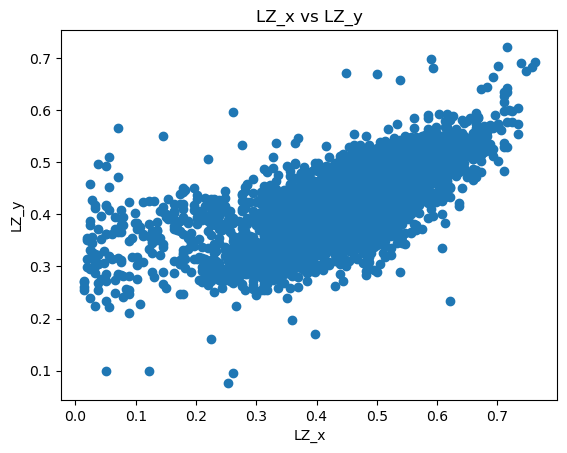

In [44]:
# plot LZ_x and LZ_y
plt.figure()
plt.scatter(df_final['LZ_x'], df_final['LZ_y'])
plt.xlabel("LZ_x")
plt.ylabel("LZ_y")
plt.title("LZ_x vs LZ_y")
plt.show()

In [34]:
import pandas as pd

# Assuming df_expe and all_dfs are your DataFrames
# You should replace these with the actual DataFrames you have

# Example DataFrames (replace these with your actual data)
# df_expe = pd.DataFrame(...) 
# all_dfs = pd.DataFrame(...)
#all_dfs['LZ'] = all_dfs['LZ_eog']
# Merge the DataFrames on 'participant', 'trial', and 'run' columns
combined_df = pd.concat([df_expe, all_dfs])

# Now combined_df will have data combined from both DataFrames based on the specified columns
df = combined_df.copy()
# keep columns participant, electrode, LZ_x, LZ_eog, trial, run
df = df[['participant', 'electrode', 'LZ', 'trial', 'bloc']]


# Create a DataFrame for electrode 1000
# Create a DataFrame for electrode 1000
df_eog = df[df['electrode'] == 1000]

# Initialize a dictionary to store correlations
correlation_results = {}

# average LZ values for each participant and each electrode
df_eog_avg = df_eog.groupby(['participant', 'electrode'])['LZ'].mean().reset_index()

# create df electrodes 0 to 269
df_electrodes = df[df['electrode'] != 1000]
df_electrodes_avg = df_electrodes.groupby(['participant', 'electrode'])['LZ'].mean().reset_index()

# compute correlation between LZ values for each electrode and LZ values for EOG
for electrode in df_electrodes_avg['electrode'].unique():
    df_electrode = df_electrodes_avg[df_electrodes_avg['electrode'] == electrode]
    df_electrode = df_electrode.sort_values(by=['participant'])
    df_eog_avg = df_eog_avg.sort_values(by=['participant'])
    print('LENGTH DF_ELECTRODE: ', len(df_electrode))
    print('LENGTH DF_EOG_AVG: ', len(df_eog_avg))
    corr = stats.pearsonr(df_electrode['LZ'], df_eog_avg['LZ'])
    correlation_results[electrode] = corr

# create df with correlation results
df_corr = pd.DataFrame.from_dict(correlation_results, orient='index')
df_corr = df_corr.reset_index()


LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_AVG:  12
LENGTH DF_ELECTRODE:  12
LENGTH DF_EOG_A

In [35]:
df_eog

participant  electrode        LZ  trial  bloc
0             0       1000  0.589299    0.0     1
1             0       1000  0.561237    1.0     1
2             0       1000  0.439636    2.0     1
3             0       1000  0.453667    3.0     1
4             0       1000  0.425605    4.0     1
..          ...        ...       ...    ...   ...
47           11       1000  0.481729   47.0     8
48           11       1000  0.486406   48.0     8
49           11       1000  0.444313   49.0     8
50           11       1000  0.509790   50.0     8
51           11       1000  0.458344   51.0     8

[4488 rows x 5 columns]

In [22]:
df_electrode

participant  electrode        LZ
269             0        269  0.354083
539             1        269  0.258486
809             2        269  0.343065
1079            3        269  0.358080
1349            4        269  0.405816
1619            5        269  0.297741
1889            6        269  0.328104
2159            7        269  0.380412
2429            8        269  0.288053
2699            9        269  0.366598
2969           10        269  0.328786
3239           11        269  0.366360

<AxesSubplot:>

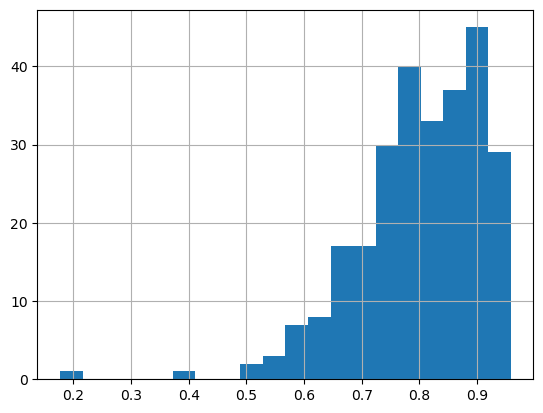

In [11]:
df_corr['statistic'].hist(bins=20)

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...
    Found the data of interest:


C:\Users\Antoine\AppData\Local\Temp\ipykernel_12924\964013619.py:5: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NUMBER OF ELECS WITH P-VALUE < 0.05 AFTER FDR CORRECTION:  270


(<Figure size 1000x500 with 2 Axes>, <AxesSubplot:>)

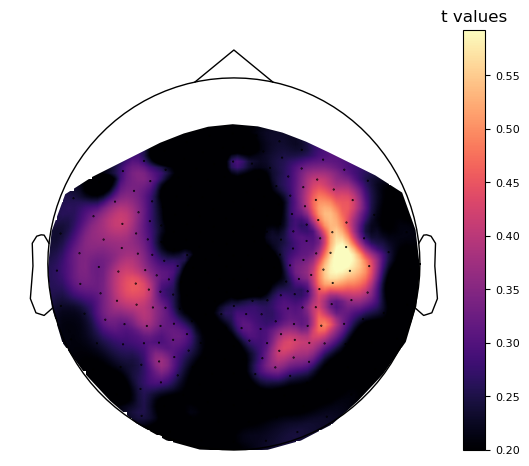

In [31]:
from MEG_pareidolia_utils import topoplot
epochs_name, epochs_path = get_pareidolia_bids(
    FOLDERPATH, "00", "pareidolia", "1", stage="epo_long", cond=None
)
epochs = mne.read_epochs(epochs_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info
# run FDR correction
from statsmodels.stats.multitest import fdrcorrection


pvals_bool = []
for p in df_corr['pvalue']:
    if p < 0.05:
        pvals_bool.append(True)
    else:
        pvals_bool.append(False)

# compute fdr correction
mask = fdrcorrection(df_corr['pvalue'], alpha=0.05, method='indep')
print("NUMBER OF ELECS WITH P-VALUE < 0.05 AFTER FDR CORRECTION: ", len(mask[0]))
topoplot(
    df_corr['statistic'],
    ch_xy,
    showtitle=False,
    titles='horizontal_eog.png',
    savefig=True,
    figpath="horizontal_eog_05",
    vmin=0.2,
    vmax=np.max(df_corr['statistic']),
    ax_title="t values",
    mask=mask[0],
    cmap="magma",
    mask_marker_size=10,
)

['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11']
LEN colors 12
PARTICIPANT:  00
PARTICIPANT:  01
PARTICIPANT:  02
PARTICIPANT:  03
PARTICIPANT:  04
PARTICIPANT:  05
PARTICIPANT:  06
PARTICIPANT:  07
PARTICIPANT:  08
PARTICIPANT:  09
PARTICIPANT:  10
PARTICIPANT:  11
TTEST LZ:  TtestResult(statistic=0.6973445194833131, pvalue=0.5000606513073551, df=11)


C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\198192678.py:39: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(parei0_LZ, hist=False, rug=True, label="no-pareidolia")
C:\Users\Antoine\AppData\Local\Temp\ipykernel_26260\198192678.py:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

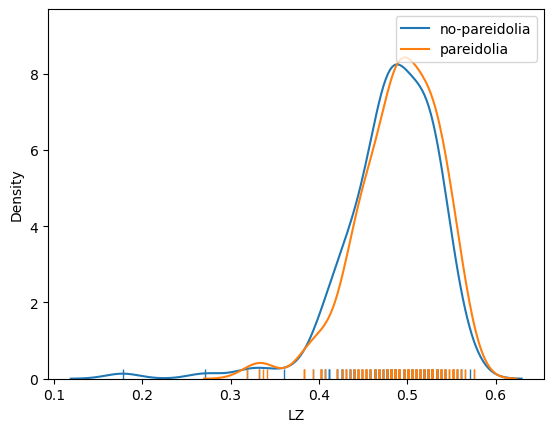

In [70]:
all_dfs
# compare LZ when parei=0 and parei=1
parei0 = all_dfs[all_dfs["parei"] == 0]
parei1 = all_dfs[all_dfs["parei"] == 1]
parei0_LZ = parei0["LZ"]
parei1_LZ = parei1["LZ"]

list_participants = all_dfs["participant"].unique()
print(list_participants)
# set n participant colors
colors = sns.color_palette("husl", len(list_participants))
# create second set with lower saturation
print('LEN colors', len(colors))
for p in list_participants:
    print("PARTICIPANT: ", p)
    parei0 = all_dfs[all_dfs["parei"] == 0]
    parei1 = all_dfs[all_dfs["parei"] == 1]
    parei0_LZ = parei0["LZ"]
    parei1_LZ = parei1["LZ"]
    parei0_LZ = parei0_LZ[parei0["participant"] == p]
    parei1_LZ = parei1_LZ[parei1["participant"] == p]
    # equal number of trials
    #min_len = min(len(parei0_LZ), len(parei1_LZ))
    # select random trials
    #parei0_LZ = parei0_LZ.sample(min_len)
    #parei1_LZ = parei1_LZ.sample(min_len)

    #ttest_LZ = stats.ttest_rel(parei0_LZ, parei1_LZ)
    #print("TTEST LZ: ", ttest_LZ)
    #sns.distplot(parei0_LZ, hist=False, rug=True, label="no-pareidolia", color=colors[list(list_participants).index(p)])
    # create color with lower alpha value
    #sns.distplot(parei1_LZ, hist=False, rug=True, label="pareidolia", color=colors[list(list_participants).index(p)])
    #plt.ylim(0, 15)
    #plt.xlim(0, 0.8)


import seaborn as sns

sns.distplot(parei0_LZ, hist=False, rug=True, label="no-pareidolia")
sns.distplot(parei1_LZ, hist=False, rug=True, label="pareidolia")
plt.legend(loc="upper right")

# remove Condition column
parei0 = parei0.drop(columns=["Condition"])
parei1 = parei1.drop(columns=["Condition"])
# average across participants
parei0_avg = parei0.groupby("participant").mean()
parei1_avg = parei1.groupby("participant").mean()

# compute t-test
ttest_LZ = stats.ttest_rel(parei0_avg["LZ"], parei1_avg["LZ"])
print("TTEST LZ: ", ttest_LZ)


c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will 

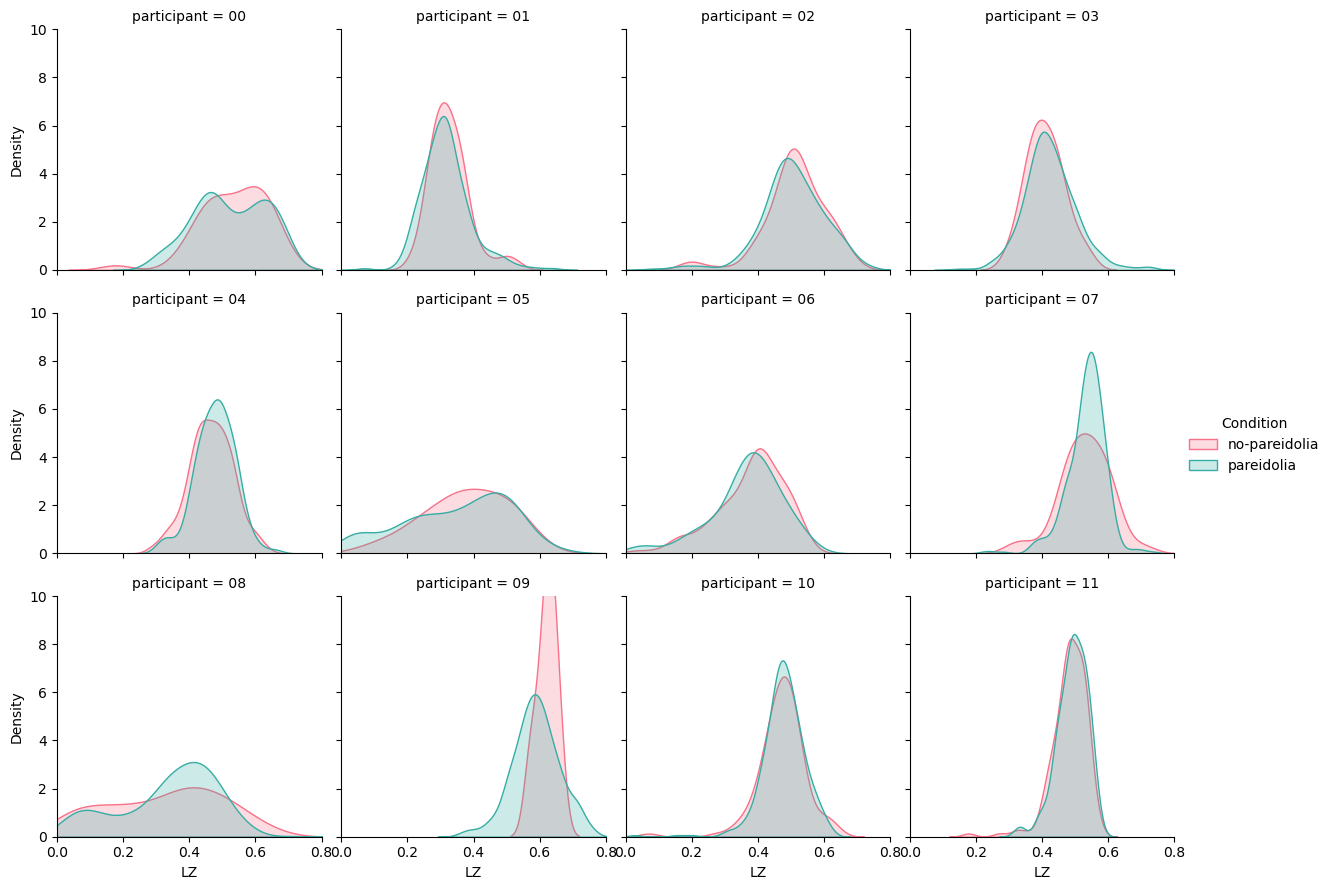

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
all_dfs['Condition'] = all_dfs['parei'].apply(lambda x: 'no-pareidolia' if x == 0 else 'pareidolia')

# Create a FacetGrid
g = sns.FacetGrid(all_dfs, col="participant", hue="Condition", col_wrap=4, height=3, palette='husl')
g = g.map(sns.kdeplot, "LZ", shade=True).add_legend()
# change xlim
g.set(xlim=(0, 0.8))
g.set(ylim=(0, 10))
plt.show()



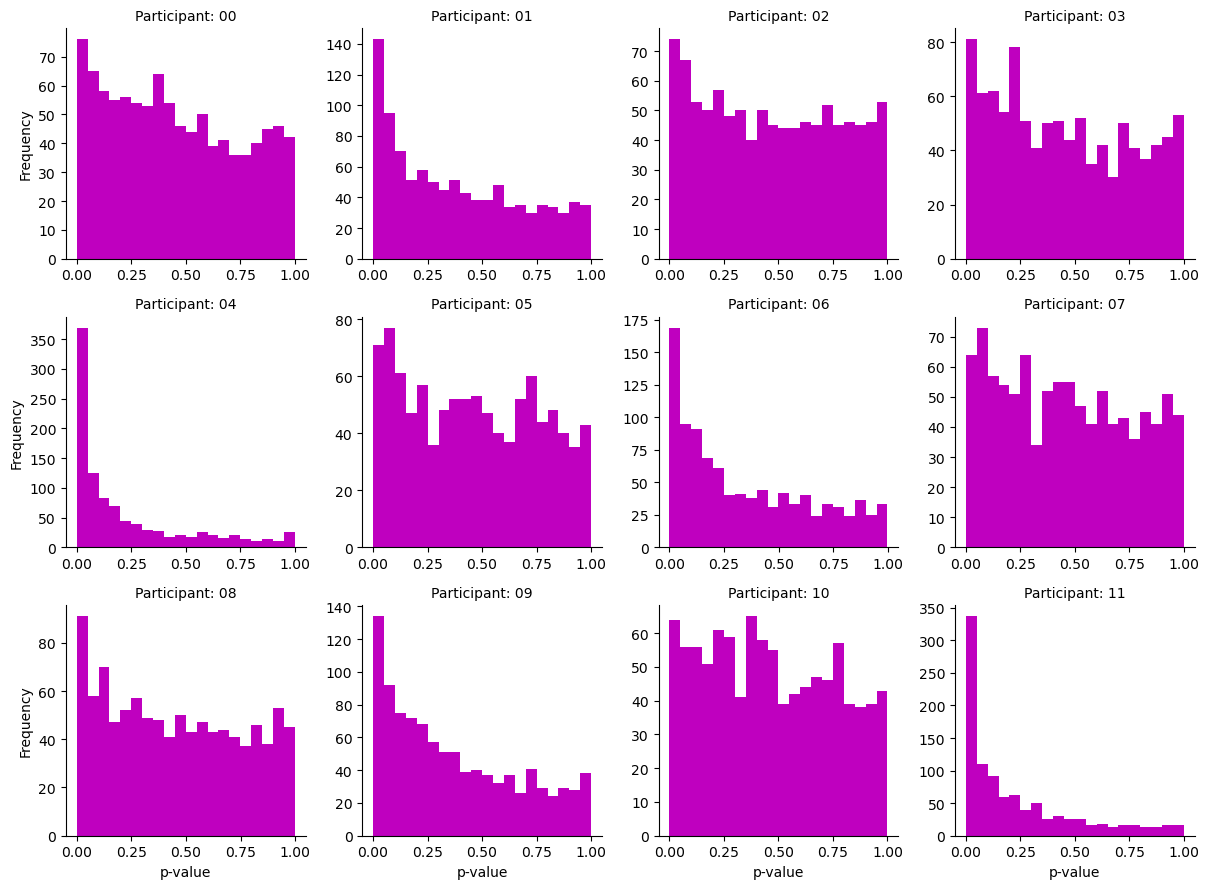

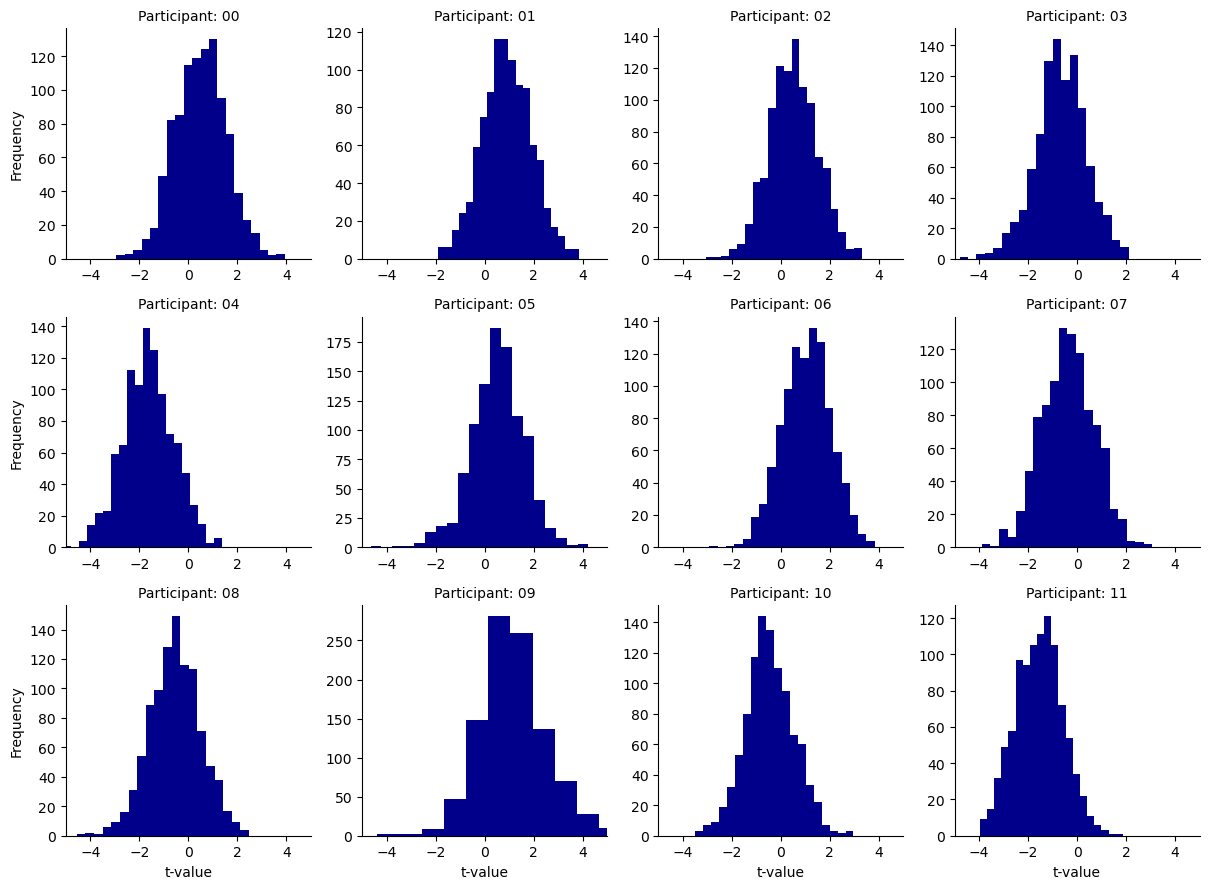

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Number of bootstrap samples
bootstrap_samples = 1000

# Initialize a DataFrame to store p-values for each participant
p_values = pd.DataFrame()
t_values = pd.DataFrame()
# Iterate over each participant
for p in list_participants:
    # Filtering the data for the current participant
    parei0_data = all_dfs[(all_dfs["parei"] == 0) & (all_dfs["participant"] == p)]["LZ"]
    parei1_data = all_dfs[(all_dfs["parei"] == 1) & (all_dfs["participant"] == p)]["LZ"]

    # Determine the minimum length for sampling
    min_len = min(len(parei0_data), len(parei1_data))

    # List to store p-values for the current participant
    p_values_participant = []
    t_values_participant = []
    # Perform bootstrapping
    for _ in range(bootstrap_samples):
        parei0_sample = parei0_data.sample(n=min_len, replace=True)
        parei1_sample = parei1_data.sample(n=min_len, replace=True)

        # Perform the t-test on the samples
        ttest_result = stats.ttest_rel(parei0_sample, parei1_sample)
        p_values_participant.append(ttest_result.pvalue)
        t_values_participant.append(ttest_result.statistic)
    # Store the p-values in the DataFrame
    p_values[p] = p_values_participant
    t_values[p] = t_values_participant

# Create a melted version of the DataFrame for plotting
melted_p_values = pd.melt(p_values, var_name="participant", value_name="p-value")
melted_t_values = pd.melt(t_values, var_name="participant", value_name="t-value")
# Create the FacetGrid for plotting
g = sns.FacetGrid(melted_p_values, col="participant", col_wrap=4, sharex=False, sharey=False)
g = g.map(plt.hist, "p-value", bins=20, color="m")
g.set_titles("Participant: {col_name}")
g.set_axis_labels("p-value", "Frequency")

g = sns.FacetGrid(melted_t_values, col="participant", col_wrap=4, sharex=False, sharey=False)
g = g.map(plt.hist, "t-value", bins=20, color="darkblue")
g.set_titles("Participant: {col_name}")
g.set_axis_labels("t-value", "Frequency")
# set xlim
g.set(xlim=(-5, 5))

plt.show()


In [21]:
list_participants

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11'], dtype=object)

EOG CHS:  ['EEG057', 'EEG058', 'EEG059']


 ...]

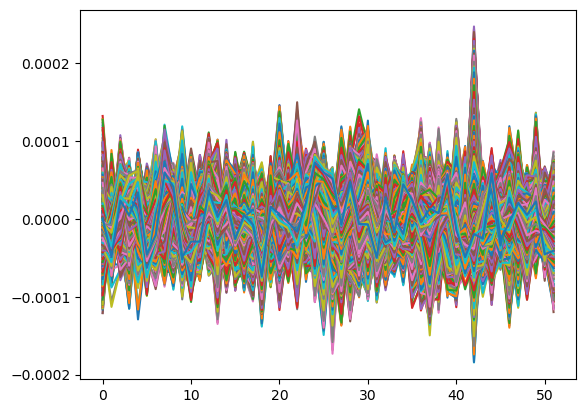

In [30]:
# find channels EOG
EOG_chs = []
for ch in epochs_short.info["ch_names"]:
    if "EEG" in ch:
        EOG_chs.append(ch)
print("EOG CHS: ", EOG_chs)
# get data from EEG057
data = epochs_short.get_data()
# get index of EEG057
idx = epochs_short.info["ch_names"].index("EEG057")
# get data from EEG057
data = data[:, idx, :]
# plot data
plt.figure()
plt.plot(data[:])



In [18]:
from mne.preprocessing import ICA
from mne.io import read_raw_fif
reproc_name, preproc_path = get_pareidolia_bids(
        FOLDERPATH, subj, task, run, stage="preproc"
    )
preproc = read_raw_fif(preproc_path, preload=True)

Opening raw data file D:\Science\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-pareidolia_run-1_preproc_raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 941999 =      0.000 ...   784.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 941999  =      0.000 ...   784.999 secs...
